# Analyzing US Science Funding Cuts Under the Trump Administration

This notebook follows the cross-industry standard process for data mining (CIRSP-DM) ([Chapman et al.](https://api.semanticscholar.org/CorpusID:59777418)). <br>
It is therefore broken down into the following sections:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Analysis and Modeling
5. Evaluation
6. Deployment

## 1. Business Understanding

US science is experiencing unprecedented funding cuts, with potentially wide-reaching consequences for different scientific topics and disciplines, development of human potential, public health, economy, and civil society. The goal of this project is to analyze the topics and (human) capital being impacted by these cuts.

## 2. Data Understanding

In [154]:
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import os

pd.set_option('display.max_rows', 50)

### 2.1 Data (Down-)Loading

In [ ]:
if os.path.exists('data_raw/nih_project_population.csv'):
    nih = pd.read_csv('data_raw/nih_project_population.csv')

if os.path.exists('data_raw/nsf_project_population.csv'):
    nsf = pd.read_csv('data_raw/nsf_project_population.csv')

#### 2.1.1 Download NIH projects and create "NIH project population at risk"

In [ ]:
def download_nih_projects(start=2014, end=2025):
    """
    Downloads all NIH project records for the requested fiscal years into a folder named 'data_raw'.

    Args:
        start: First fiscal year that should be included.
        end: Last fiscal year that should be included.

    """

    path = Path('data_raw/nih/')
    path.mkdir(parents=True, exist_ok=True)
   
    url = "https://reporter.nih.gov/exporter/projects/download/"
    base_name = "data_raw/nih/RePORTER_PRJ_C_FY"

    for year in range(start, end + 1):
        if not os.path.exists(base_name + f'{year}.zip'):
            response = requests.get(url + str(year))

            if response.status_code == 200:
                with open(base_name + f'{year}.zip', "wb") as file:
                    file.write(response.content)
                print(f"Download {base_name + str(year)} completed!")
            else:
                print(f"Error for {base_name + str(year)}: {response.status_code}")

def download_nih_abstracts(start=2014, end=2025):
    """
    Downloads all NIH project abstracts for the requested fiscal years into a folder named 'data_raw'.

    Args:
        start: First fiscal year that should be included.
        end: Last fiscal year that should be included.

    """

    path = Path('data_raw/nih/')
    path.mkdir(parents=True, exist_ok=True)

    url = "https://reporter.nih.gov/exporter/abstracts/download/"
    base_name = "data_raw/nih/RePORTER_PRJABS_C_FY"

    for year in range(start, end + 1):
        if not os.path.exists(base_name + f'{year}.zip'):
            response = requests.get(url + str(year))

            if response.status_code == 200:
                with open(base_name + f'{year}.zip', "wb") as file:
                    file.write(response.content)
                print(f"Download {base_name + str(year)} completed!")
            else:
                print(f"Error for {base_name + str(year)}: {response.status_code}")

def download_nih_grant_whitness():
    """
    Downloads all records of NIH projects which were affected by the funding cuts of the Trump administration
    from grant-whtiness.us for the requested fiscal years into a folder named 'data_raw'.

    """
    path = Path('data_raw/nih/')
    path.mkdir(parents=True, exist_ok=True)

    url = "https://files.grant-witness.us/nih_terminations.csv"
    filename = "data_raw/nih/nih_terminations.csv"
    if not os.path.exists(filename):
        response = requests.get(url)

        if response.status_code == 200:
            with open(filename, "wb") as file:
                file.write(response.content)
            print(f"Download {filename} completed!")
        else:
            print(f"Error for {filename}: {response.status_code}")

In [ ]:
if not os.path.exists('data_raw/nih_project_population.csv'):
    download_nih_projects()
    download_nih_abstracts()
    download_nih_grant_whitness()

In [ ]:
def merge_nih_prj_abs(start=2014, end=2025):
    """
    Merges NIH project records and corresponding abstract texts into a single dataframe.

    Args:
        start: First fiscal year that should be included.
        end: Last fiscal year that should be included.
    
    Returns:
        pd.DataFrame: Pandas dataframe consisting of all previously downloaded NIH projects and corresponding abstracts.
    """

    projects = pd.read_csv(f'data_raw/nih/RePORTER_PRJ_C_FY{start}.zip', encoding='latin1')
    for year in range(start + 1, end + 1):
        projects = pd.concat([projects, pd.read_csv(f'data_raw/nih/RePORTER_PRJ_C_FY{year}.zip', encoding='latin1')], axis=0)

    abstracts = pd.read_csv(f'data_raw/nih/RePORTER_PRJABS_C_FY{start}.zip', encoding='latin1')
    for year in range(start + 1, end + 1):
        abstracts = pd.concat([abstracts, pd.read_csv(f'data_raw/nih/RePORTER_PRJABS_C_FY{year}.zip', encoding='latin1')], axis=0)

    # there are duplicate abstracts for the same ID -> drop them
    abstracts = abstracts.drop_duplicates(subset=['APPLICATION_ID'], keep='first')

    nih = pd.merge(projects, abstracts, how='left', on='APPLICATION_ID')
    return nih

if not os.path.exists('data_raw/nih_project_population.csv'):
    nih = merge_nih_prj_abs()

In [ ]:
def load_nih_grant_whitness_data():
    """
    Loads the previously downloaded NIH records from grant-whitness.us into a pd.DataFrame 
    and ensure that all records have a unique core_award_number.
    
    Returns:
        pd.DataFrame: DataFrame consisting of all previously downloaded uniquely identifiable NIH projects from grant-whitness.us.
    """
    
    nih_gw_load = pd.read_csv('data_raw/nih/nih_terminations.csv')

    # make core_award_number unique by summing all financial information by core_award_number and keeping the latest value for all other columns
    all_columns = nih_gw_load.columns
    agg_logic = {col: 'first' for col in all_columns if col != 'core_award_number'}
    agg_logic['total_estimated_outlays'] = 'sum'
    agg_logic['total_estimated_remaining'] = 'sum'
    nih_gw = nih_gw_load.groupby('core_award_number', as_index=False).agg(agg_logic)
    return nih_gw

if not os.path.exists('data_raw/nih_project_population.csv'):
    nih_gw = load_nih_grant_whitness_data()

In [ ]:
def merge_nih_with_gw():
    """
    Merges downloaded NIH data and records from grant-whitness.us into a single pd.DataFrame.
    Computes a total project budget for all uniquely identifiable projects and restricts all records 
    to the latest record (latest fiscal year).
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: The merged dataframe and a dataframe of data from grant-whitness.us for which 
        no project in the downloaded NIH project period could be found.
    """

    missing_mask = ~nih_gw['core_award_number'].isin(nih['CORE_PROJECT_NUM'])
    nih_gw_orphans = nih_gw[missing_mask]

    nih['TOTAL_PROJECT_BUDGET'] = nih.groupby('CORE_PROJECT_NUM', dropna=False)['TOTAL_COST'].transform('sum')
    nih_full = pd.merge(nih, nih_gw, how='left', left_on='CORE_PROJECT_NUM', right_on='core_award_number')

    nih_final = nih_full.sort_values('FY', ascending=False)
    nih_final = nih_final.drop_duplicates(subset='CORE_PROJECT_NUM')

    return nih_final, nih_gw_orphans

if not os.path.exists('data_raw/nih_project_population.csv'):
    nih_merged, nih_gw_missing = merge_nih_with_gw()

In [ ]:
def create_nih_prj_pop():
    """
    Creates the "NIH project population at risk". This refers to all NIH projects that
    a) were active when Trump came into office
    b) were inactive but receiving money (projects in their closeout phase).
    Projects b) are projects that have an end date earlier 2025-01-20 and either appear in FY 2025 or 
    do not appear there (because they were cancelled before they received their first payement in 2025) but are
    recorded on grant-whitness.us.
    
    Returns:
        pd.DataFrame: The final dataframe consisting of all NIH projects at risk when Trump came into office.
    """

    nih_merged['PROJECT_END'] = pd.to_datetime(nih_merged['PROJECT_END'])
    nih_prj_pop_at_risk = nih_merged[(nih_merged['PROJECT_END'] >= pd.Timestamp('2025-01-20')) | (nih_merged['FY'] == 2025) | (nih_merged['status'].notna())]
    return nih_prj_pop_at_risk

if not os.path.exists('data_raw/nih_project_population.csv'):
    nih_prj_pop = create_nih_prj_pop()
    nih_prj_pop.to_csv('data_raw/nih_project_population.csv')

In [ ]:
if not os.path.exists('data_raw/nih_project_population.csv'):
    nih_gw_missing[['core_award_number', 'appl_id', 'status', 'targeted_start_date', 'targeted_end_date', 'project_title', 'abstract_text', 'total_estimated_outlays', 'total_estimated_remaining']]

,core_award_number,appl_id,status,targeted_start_date,targeted_end_date,project_title,abstract_text,total_estimated_outlays,total_estimated_remaining
0,AY2AX000005,NaN,🚰 Unfrozen Funding,2025-04-14,2025-09-03,None,None,26075910.6,43791133.4
1,AY2AX000012,NaN,🚰 Unfrozen Funding,2025-04-08,2025-07-23,None,None,9874704.0,5658428.0
2,AY2AX000031,NaN,💧 Possibly Unfrozen Funding,2025-04-14,2025-09-03,None,None,3884147.0,18126233.0
6,CP1MP211244,NaN,❌ Terminated,None,None,None,None,0.0,0.0
257,F31AI188876,NaN,❌ Terminated,None,None,None,None,0.0,0.0
258,F31AI188916,NaN,❌ Terminated,None,None,None,None,0.0,0.0
365,F31DK137479,NaN,❌ Terminated,None,None,None,None,0.0,0.0
384,F31DK142454,NaN,❌ Terminated,None,None,None,None,0.0,0.0
4775,T32AG000163,NaN,❌ Terminated,None,None,None,None,0.0,0.0


We can see that the only grant-whitness.us projects which could not be found in the NIH projects do not contain any real meaningful information for our analysis. They either have no recorded financial information or are missing content information (title, abstract). For our analysis we need both. Also, the 3 projects among them which contain financial information are projects which are essentially unaffected by the funding cuts since they were most likely reinstated or unfrozen. Therefore, we don't miss any crucial information when omitting them.

#### 2.1.2 Download NSF projects and create "NSF project population at risk"

In [77]:
import json
import zipfile

NSF project data has to be manually downlaoded from the [NSF Website](https://www.nsf.gov/awardsearch/download-awards/).
Similarly to the NIH data, we download all data from 2014-2025. <br>
Then, we put them in the subfolder `data_raw/nsf/`.

In [ ]:
def download_nsf_grant_whitness():
    """
    Downloads all records of NSF projects which were affected by the funding cuts of the Trump administration
    from grant-whtiness.us for the requested fiscal years into a folder named 'data_raw'.

    """
    path = Path('data_raw/nsf/')
    path.mkdir(parents=True, exist_ok=True)

    url = "https://files.grant-witness.us/nsf_terminations.csv"
    filename = "data_raw/nsf/nsf_terminations.csv"
    if not os.path.exists(filename):
        response = requests.get(url)

        if response.status_code == 200:
            with open(filename, "wb") as file:
                file.write(response.content)
            print(f"Download {filename} completed!")
        else:
            print(f"Error for {filename}: {response.status_code}")

if not os.path.exists('data_raw/nsf_project_population.csv'):
    download_nsf_grant_whitness()

In [78]:
def flatten_nsf_json(data):
    """
    Extracts relevant fields from the nested NSF JSON structure 
    and flattens them into a single-level dictionary.
    """
    row = {
        'awd_id': data.get('awd_id'),
        'awd_titl_txt': data.get('awd_titl_txt'),
        'awd_eff_date': data.get('awd_eff_date'),
        'awd_exp_date': data.get('awd_exp_date'),
        'awd_amount': data.get('awd_amount'),
        'tot_intn_awd_amt': data.get('tot_intn_awd_amt'),
        'org_dir_long_name': data.get('org_dir_long_name'),
        'org_div_long_name': data.get('org_div_long_name'),
        'abstract': data.get('awd_abstract_narration'),
    }

    # Extract Institution information
    inst = data.get('inst')
    if inst:
        row['inst_name'] = inst.get('inst_name')
        row['inst_state'] = inst.get('inst_state_code')

    # Extract the primary Principal Investigator (PI)
    pi_list = data.get('pi', [])
    if pi_list:
        # CHANGED: Extract first and last name separately instead of full name
        row['pi_first_name'] = pi_list[0].get('pi_first_name')
        row['pi_last_name'] = pi_list[0].get('pi_last_name')

    # Extract and join Program Elements (PGM) into a single string
    pgm = data.get('pgm_ele', [])
    if pgm:
        row['pgm_names'] = ", ".join([p.get('pgm_ele_name', '') for p in pgm])

    return row

def load_nsf_data():
    # Path configuration
    base_dir = "data_raw/nsf"
    all_project_data = []

    # Verify if directory exists
    if not os.path.exists(base_dir):
        print(f"Error: Directory '{base_dir}' not found.")
    else:
        for filename in os.listdir(base_dir):
            if filename.endswith(".zip"):
                zip_path = os.path.join(base_dir, filename)
                print(f"Processing year archive: {filename}...")
                with zipfile.ZipFile(zip_path, 'r') as z:
                    for json_filename in z.namelist():
                        # Only process JSON files
                        if json_filename.endswith(".json"):
                            # Open and read the JSON content directly from the ZIP
                            with z.open(json_filename) as f:
                                try:
                                    data = json.load(f)
                                    flattened_row = flatten_nsf_json(data)
                                    
                                    # Add the source filename as metadata to track the Fiscal Year
                                    flattened_row['source_year'] = filename.split('.')[0]
                                    all_project_data.append(flattened_row)
                                except json.JSONDecodeError:
                                    print(f"Warning: Could not decode JSON for {json_filename} in {filename}.")

        # Create the final DataFrame
        nsf = pd.DataFrame(all_project_data)

        # Summary Output
        print("-" * 30)
        print(f"Successfully loaded: {len(nsf)} NSF projects.")
        print(f"Columns available: {list(nsf.columns)}")
        
        return nsf
    
if not os.path.exists('data_raw/nsf_project_population.csv'):
    nsf = load_nsf_data()

Processing year archive: 2024.zip...
Processing year archive: 2018.zip...
Processing year archive: 2019.zip...
Processing year archive: 2025.zip...
Processing year archive: 2021.zip...
Processing year archive: 2020.zip...
Processing year archive: 2022.zip...
Processing year archive: 2023.zip...
Processing year archive: 2014.zip...
Processing year archive: 2015.zip...
Processing year archive: 2017.zip...
Processing year archive: 2016.zip...
------------------------------
Successfully loaded: 144787 NSF projects.
Columns available: ['awd_id', 'awd_titl_txt', 'awd_eff_date', 'awd_exp_date', 'awd_amount', 'tot_intn_awd_amt', 'org_dir_long_name', 'org_div_long_name', 'abstract', 'inst_name', 'inst_state', 'pi_first_name', 'pi_last_name', 'pgm_names', 'source_year']


In [79]:
def load_nsf_grant_whitness_data():
    """
    Loads the previously downloaded NSF records from grant-whitness.us into a pd.DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame consisting of all previously downloaded NSF projects from grant-whitness.us.
    """
    
    nsf_gw = pd.read_csv('data_raw/nsf/nsf_terminations.csv')
    nsf_gw['grant_id'] = nsf_gw['grant_id'].astype('string')

    return nsf_gw

if not os.path.exists('data_raw/nsf_project_population.csv'):
    nsf_gw = load_nsf_grant_whitness_data()

In [80]:
def merge_nsf_with_gw():
    """
    Merges downloaded NSF data and records from grant-whitness.us into a single pd.DataFrame.
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: The merged dataframe and a dataframe of data from grant-whitness.us for which 
        no project in the downloaded NSF project period could be found.
    """

    missing_mask = ~nsf_gw['grant_id'].isin(nsf['awd_id'])
    nsf_gw_orphans = nsf_gw[missing_mask]

    nsf_full = pd.merge(nsf, nsf_gw, how='left', left_on='awd_id', right_on='grant_id')

    return nsf_full, nsf_gw_orphans

if not os.path.exists('data_raw/nsf_project_population.csv'):
    nsf_merged, nsf_gw_missing = merge_nsf_with_gw()

In [81]:
def create_nsf_prj_pop():
    """
    Creates the "NSF project population at risk". This refers to all NSF projects that were active when Trump came into office.
    
    Returns:
        pd.DataFrame: The final dataframe consisting of all NSF projects at risk when Trump came into office.
    """

    nsf_merged['awd_exp_date'] = pd.to_datetime(nsf_merged['awd_exp_date'])
    nsf_prj_pop_at_risk = nsf_merged[(nsf_merged['awd_exp_date'] >= pd.Timestamp('2025-01-20')) | (nsf_merged['status'].notna())]
    return nsf_prj_pop_at_risk

if not os.path.exists('data_raw/nsf_project_population.csv'):
    nsf_prj_pop = create_nsf_prj_pop()
    nsf_prj_pop.to_csv('data_raw/nsf_project_population.csv')

In [82]:
nsf_gw_missing[['grant_id', 'status', 'nsf_start_date', 'nsf_end_date', 'project_title', 'abstract', 'usasp_outlaid', 'estimated_remaining']]

,grant_id,status,nsf_start_date,nsf_end_date,project_title,abstract,usasp_outlaid,estimated_remaining
580,1231319,🔄 Possibly Reinstated,2013-10-01,2026-03-31,Center for Integrated Quantum Materials,****Abstract***\r\n\r\nThe Science and Technol...,12794466.1,31639926.9


### 2.2 Feature Selection and Categorization 

To understand the meaning of the columns better, we put them into more high-level groups and organize the data frames' columns into a corresponding multi-index. 

In [89]:
print(*nih.columns, sep='\n')

Unnamed: 0
APPLICATION_ID
ACTIVITY
ADMINISTERING_IC
APPLICATION_TYPE
ARRA_FUNDED
AWARD_NOTICE_DATE
BUDGET_START
BUDGET_END
CFDA_CODE
CORE_PROJECT_NUM
ED_INST_TYPE
OPPORTUNITY NUMBER
FULL_PROJECT_NUM
FUNDING_ICs
FUNDING_MECHANISM
FY
IC_NAME
NIH_SPENDING_CATS
ORG_CITY
ORG_COUNTRY
ORG_DEPT
ORG_DISTRICT
ORG_DUNS
ORG_FIPS
ORG_IPF_CODE
ORG_NAME
ORG_STATE
ORG_ZIPCODE
PHR
PI_IDS
PI_NAMEs
PROGRAM_OFFICER_NAME
PROJECT_START
PROJECT_END
PROJECT_TERMS
PROJECT_TITLE
SERIAL_NUMBER
STUDY_SECTION
STUDY_SECTION_NAME
SUBPROJECT_ID
SUFFIX
SUPPORT_YEAR
DIRECT_COST_AMT
INDIRECT_COST_AMT
TOTAL_COST
TOTAL_COST_SUB_PROJECT
ASSISTANCE_LISTING_NUMBER
ABSTRACT_TEXT
TOTAL_PROJECT_BUDGET
core_award_number
status
full_award_number
hhs_web_reported
hhs_pdf_reported
self_reported
court_reported
source_reported
targeted_start_date
targeted_end_date
ever_frozen
frozen_date
unfrozen_date
file_c_outlays
termination_date
cancellation_source
reinstatement_indicator
reinstated_est_date
reinstatement_case
last_payment_month


In [90]:
print(*nsf.columns, sep='\n')

Unnamed: 0
awd_id
awd_titl_txt
awd_eff_date
awd_exp_date
awd_amount
tot_intn_awd_amt
org_dir_long_name
org_div_long_name
abstract_x
inst_name
inst_state
pi_first_name
pi_last_name
pgm_names
source_year
grant_id
status
terminated
suspended
termination_date
termination_indicator
reinstated
reinstatement_date
reinstatement_indicator
cruz_list
nsf_url
usaspending_url
project_title
abstract_y
org_name
org_state
org_city
award_type
usasp_start_date
usasp_end_date
nsf_start_date
nsf_end_date
nsf_program_name
nsf_primary_program
usasp_nsf_office
nsf_total_budget
nsf_obligated
usasp_total_obligated
usasp_obligation_hist
usasp_total_obligated_corrected
usasp_outlaid
estimated_budget
estimated_outlays
estimated_remaining
post_termination_deobligation
division
directorate
div
dir
record_sha1


In [91]:
##################
#### NIH Data ####
##################

nih_selection = pd.DataFrame()

# ID
nih_selection['id'] = nih['CORE_PROJECT_NUM'].astype('string')

# STATUS
nih_selection['cancellation_source'] = nih['cancellation_source'].astype('string')
nih_selection['ever_frozen'] = nih['ever_frozen'].astype('boolean')
nih_selection['reinstatement_indicator'] = nih['reinstatement_indicator'].astype('string')
nih_selection['status'] = nih['status'].astype('string')

# CONTEXT
nih_selection['admin_ic'] = nih['ADMINISTERING_IC'].astype('string')
nih_selection['admin_ic_name'] = nih['IC_NAME'].astype('string')
nih_selection['institution_type'] = nih['org_type'].fillna(nih['ED_INST_TYPE']).astype('string')
nih_selection['spending_categories'] = nih['spending_categories'].fillna(nih['NIH_SPENDING_CATS']).astype('string')
nih_selection['inst_city'] = nih['ORG_CITY'].astype('string')
nih_selection['inst_state'] = nih['org_state'].fillna(nih['ORG_STATE']).astype('string')
nih_selection['inst_country'] = nih['ORG_COUNTRY'].astype('string')
nih_selection['inst_department'] = nih['dept_type'].fillna(nih['ORG_DEPT']).astype('string')
nih_selection['inst_congressional_district'] = nih['org_congdist'].fillna(nih['ORG_DISTRICT']).astype('string')
nih_selection['inst_name'] = nih['org_name'].fillna(nih['ORG_NAME']).astype('string')
nih_selection['pi_names'] = nih['PI_NAMEs'].astype('string')
nih_selection['review_group'] = nih['STUDY_SECTION'].astype('string')
nih_selection['review_group_name'] = nih['study_section'].fillna(nih['STUDY_SECTION_NAME']).astype('string')

# TIME
nih_selection['project_start'] = pd.to_datetime(nih['PROJECT_START'])
nih_selection['project_end'] = pd.to_datetime(nih['PROJECT_END'])
nih_selection['frozen_date'] = pd.to_datetime(nih['frozen_date'])
nih_selection['unfrozen_date'] = pd.to_datetime(nih['unfrozen_date'])
nih_selection['termination_date'] = pd.to_datetime(nih['termination_date'])
nih_selection['reinstated_date'] = pd.to_datetime(nih['reinstated_est_date'])
nih_selection['last_payment_date'] = pd.to_datetime(nih['last_payment_date'])

# FINANCE
nih_selection['project_budget'] = nih['TOTAL_PROJECT_BUDGET'].astype('float64')
nih_selection['budget_outlays'] = nih['total_estimated_outlays'].astype('float64')
nih_selection['budget_remaining'] = nih['total_estimated_remaining'].astype('float64')

# CONTENT
nih_selection['title'] = nih['project_title'].fillna(nih['PROJECT_TITLE']).astype('string')
nih_selection['abstract'] = nih['abstract_text'].fillna(nih['ABSTRACT_TEXT']).astype('string')
nih_selection['terms'] = nih['terms'].fillna(nih['PROJECT_TERMS']).astype('string')
nih_selection['flagged_words'] = nih['flagged_words'].astype('string')

#### CREATE MULTI-COLUMN-INDEX ####
nih_selection_mapping = {
    # ID
    'id': 'id',
    
    # STATUS
    'cancellation_source': 'status',
    'ever_frozen': 'status',
    'reinstatement_indicator': 'status',
    'status': 'status',
    
    # CONTEXT
    'admin_ic': 'context',
    'admin_ic_name': 'context',
    'institution_type': 'context',
    'spending_categories': 'context',
    'inst_city': 'context',
    'inst_state': 'context',
    'inst_country': 'context',
    'inst_department': 'context',
    'inst_congressional_district': 'context',
    'inst_name': 'context',
    'pi_names': 'context',
    'review_group': 'context',
    'review_group_name': 'context',
    
    # TIME
    'project_start': 'time',
    'project_end': 'time',
    'frozen_date': 'time',
    'unfrozen_date': 'time',
    'termination_date': 'time',
    'reinstated_date': 'time',
    'last_payment_date': 'time',
    
    # FINANCE
    'project_budget': 'finance',
    'budget_outlays': 'finance',
    'budget_remaining': 'finance',
    
    # CONTENT
    'title': 'content',
    'abstract': 'content',
    'terms': 'content',
    'flagged_words': 'content'
}

nih_selection.columns = pd.MultiIndex.from_tuples(
    [(nih_selection_mapping.get(col, 'other'), col) for col in nih_selection.columns],
    names=['category', 'variable']
)

category_order = ['id', 'status', 'context', 'time', 'finance', 'content']
nih = nih_selection.reindex(columns=category_order, level='category')

In [92]:
##################
#### NSF Data ####
##################

nsf_selection = pd.DataFrame()

# ID
nsf_selection['id'] = nsf['awd_id'].astype('string')

# STATUS
nsf_selection['status'] = nsf['status'].astype('string')
nsf_selection['reinstatement_indicator'] = nsf['reinstatement_indicator'].astype('string')
nsf_selection['termination_indicator'] = nsf['termination_indicator'].astype('string')

# CONTEXT
nsf_selection['nsf_program'] = nsf['pgm_names'].astype('string')
nsf_selection['nsf_directorate'] = nsf['org_dir_long_name'].astype('string')
nsf_selection['nsf_division'] = nsf['org_div_long_name'].astype('string')
nsf_selection['inst_state'] = nsf['inst_state'].astype('string')
nsf_selection['inst_name'] = nsf['inst_name'].astype('string')
nsf_selection['pi_first_name'] = nsf['pi_first_name'].astype('string')
nsf_selection['pi_last_name'] = nsf['pi_last_name'].astype('string')

# TIME
nsf_selection['project_start'] = pd.to_datetime(nsf['awd_eff_date'])
nsf_selection['project_end'] = pd.to_datetime(nsf['awd_exp_date'])
nsf_selection['termination_date'] = pd.to_datetime(nsf['termination_date'])
nsf_selection['usasp_start'] = pd.to_datetime(nsf['usasp_start_date'])
nsf_selection['usasp_end'] = pd.to_datetime(nsf['usasp_end_date'])

# FINANCE
nsf_selection['project_budget'] = nsf['tot_intn_awd_amt'].astype('float64')
nsf_selection['budget_outlays'] = nsf['estimated_outlays'].astype('float64')
nsf_selection['budget_remaining'] = nsf['estimated_remaining'].astype('float64')
nsf_selection['usasp_outlays'] = nsf['usasp_outlaid'].astype('float64')

# CONTENT
nsf_selection['title'] = nsf['abstract_y'].fillna(nsf['abstract_x']).astype('string')
nsf_selection['abstract'] = nsf['project_title'].fillna(nsf['awd_titl_txt']).astype('string')

nsf_selection_mapping = {
    # ID
    'id': 'id',
    
    # STATUS
    'status': 'status',
    'reinstatement_indicator': 'status',
    'termination_indicator': 'status',
    
    # CONTEXT
    'nsf_program': 'context',
    'nsf_directorate': 'context',
    'nsf_division': 'context',
    'inst_state': 'context',
    'inst_name': 'context',
    'pi_first_name': 'context',
    'pi_last_name': 'context',
    
    # TIME
    'project_start': 'time',
    'project_end': 'time',
    'termination_date': 'time',
    'usasp_start': 'time',
    'usasp_end': 'time',
    
    # FINANCE
    'project_budget': 'finance',
    'budget_outlays': 'finance',
    'budget_remaining': 'finance',
    'usasp_outlays': 'finance',
    
    # CONTENT
    'title': 'content',
    'abstract': 'content'
}

nsf_selection.columns = pd.MultiIndex.from_tuples(
    [(nsf_selection_mapping.get(col, 'other'), col) for col in nsf_selection.columns],
    names=['category', 'variable']
)

category_order = ['id', 'status', 'context', 'time', 'finance', 'content']
nsf = nsf_selection.reindex(columns=category_order, level='category')

### 2.3 Feature Summary

In [93]:
from pandas.api.types import is_numeric_dtype, is_bool_dtype

def feature_summary(data):

    def count_outliers_iqr(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        return len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])

    summary = pd.DataFrame({
        'category': [], 'variable': [], 'datatype': [], 'missing_val_count': [], 'missing_val_pct': [], 'existing_val_count': [], 'distinct_val_count': [],
        'mode': [], 'mean': [], 'std': [], 'q25': [], 'median': [], 'q75': [], 'outliers': []
    })
    for col in data.columns:
        summary = pd.concat([summary, pd.DataFrame({
        'category': [col[0]], 
        'variable': [col[1]], 
        'datatype': [data[col].dtype], 
        'missing_val_count': [sum(data[col].isna())],
        'missing_val_pct': [sum(data[col].isna()) / len(data)], 
        'existing_val_count': [sum((data[col].isna() == False))], 
        'distinct_val_count': [data[col].value_counts().count()],
        'mode': [list(data[col].mode().values) if len(list(data[col].mode().values)) > 1 else data[col].mode()[0]], 
        'mean': [round(data[col].mean(), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'std': [round(data[col].std(), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'q25': [round(data[col].quantile(0.25), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'median': [round(data[col].median(), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'q75': [round(data[col].quantile(0.75), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'outliers': [count_outliers_iqr(data, col) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
    })])

    summary['category'] = pd.Categorical(summary['category'], categories=['id', 'status', 'context', 'time', 'finance', 'content'], ordered=True)   
    summary.sort_values('category', inplace=True) 
    return summary

In [94]:
nih_summary = feature_summary(nih)
nih_summary

,category,variable,datatype,missing_val_count,missing_val_pct,existing_val_count,distinct_val_count,mode,mean,std,q25,median,q75,outliers
0,id,id,string[python],0.0,0.000000,89313.0,89313.0,"[26115002B91020F00004, 26116004B91021F00210, 2...",NaN,NaN,NaN,NaN,NaN,NaN
0,status,cancellation_source,string[python],83860.0,0.938945,5453.0,5.0,No USAspending payments,NaN,NaN,NaN,NaN,NaN,NaN
0,status,ever_frozen,boolean,83860.0,0.938945,5453.0,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN
0,status,reinstatement_indicator,string[python],87137.0,0.975636,2176.0,28.0,"AAUP-Harvard v DOJ, Harvard v HHS",NaN,NaN,NaN,NaN,NaN,NaN
0,status,status,string[python],83860.0,0.938945,5453.0,5.0,🔄 Possibly Reinstated,NaN,NaN,NaN,NaN,NaN,NaN
0,context,review_group_name,string[python],1671.0,0.018709,87642.0,7435.0,NSS,NaN,NaN,NaN,NaN,NaN,NaN
0,context,review_group,string[python],1727.0,0.019336,87586.0,425.0,ZRG1,NaN,NaN,NaN,NaN,NaN,NaN
0,context,inst_name,string[python],71.0,0.000795,89242.0,4362.0,JOHNS HOPKINS UNIVERSITY,NaN,NaN,NaN,NaN,NaN,NaN
0,context,inst_congressional_district,string[python],3348.0,0.037486,85965.0,268.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
0,context,inst_department,string[python],23335.0,0.261272,65978.0,46.0,INTERNAL MEDICINE/MEDICINE,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
nsf_summary = feature_summary(nsf)
nsf_summary

,category,variable,datatype,missing_val_count,missing_val_pct,existing_val_count,distinct_val_count,mode,mean,std,q25,median,q75,outliers
0,id,id,string[python],0.0,0.000000,54294.0,54294.0,"[1202910, 1326927, 1400450, 1419935, 1421197, ...",NaN,NaN,NaN,NaN,NaN,NaN
0,status,status,string[python],52299.0,0.963256,1995.0,2.0,❌ Terminated,NaN,NaN,NaN,NaN,NaN,NaN
0,status,reinstatement_indicator,string[python],53662.0,0.988360,632.0,5.0,Thakur v. Trump (Aug 2025),NaN,NaN,NaN,NaN,NaN,NaN
0,status,termination_indicator,string[python],52299.0,0.963256,1995.0,8.0,"Added to NSF CSV, research.gov",NaN,NaN,NaN,NaN,NaN,NaN
0,context,pi_first_name,string[python],0.0,0.000000,54294.0,10957.0,David,NaN,NaN,NaN,NaN,NaN,NaN
0,context,inst_name,string[python],0.0,0.000000,54294.0,3803.0,Regents of the University of Michigan - Ann Arbor,NaN,NaN,NaN,NaN,NaN,NaN
0,context,inst_state,string[python],60.0,0.001105,54234.0,59.0,CA,NaN,NaN,NaN,NaN,NaN,NaN
0,context,pi_last_name,string[python],0.0,0.000000,54294.0,21432.0,Wang,NaN,NaN,NaN,NaN,NaN,NaN
0,context,nsf_directorate,string[python],1.0,0.000018,54293.0,10.0,Directorate for Mathematical and Physical Scie...,NaN,NaN,NaN,NaN,NaN,NaN
0,context,nsf_program,string[python],59.0,0.001087,54235.0,6831.0,IUSE,NaN,NaN,NaN,NaN,NaN,NaN


### 2.4 Visual inspection of the features

In [96]:
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def plot_features(data, data_summary, figsize, categorical_cols = [], outlier_robust = True):  
    numerical_cols = [(col[1]['category'], col[1]['variable']) for col in data_summary.iterrows() if col[1]['datatype'] == 'float64']
    #max_categories = 15
    #categorical_cols = [(col[1]['category'], col[1]['variable']) for col in data_summary.iterrows() if (col[1]['datatype'] != 'float64') and (len(data[(col[1]['category'], col[1]['variable'])].value_counts()) <= max_categories)]
    col_names = numerical_cols + categorical_cols

    num_plots = len(col_names)
    ncols = 3
    nrows = math.ceil(num_plots / 3)

    i = 0
    for row in range(0, nrows):
        fig, ax = plt.subplots(1, ncols, figsize=figsize)
        for col in range(0, ncols):
            try:
                dat_plot = data[col_names[i]]
                dat_plot = dat_plot[dat_plot.isna() == False]
                if dat_plot.dtype == 'boolean':
                    dat_plot = dat_plot.astype('int64')

                if col_names[i] in categorical_cols:
                    dat_plot = dat_plot.value_counts()
                    if outlier_robust:
                        dat_plot = dat_plot[0:15]
                    dat_plot.plot(kind='bar', ax=ax[col])
                    ax[col].set_title(f"{col_names[i][1]} (top 15 values)")
                    if data_summary[data_summary['variable'] == col_names[i][1]]['datatype'].values == 'boolean':
                        ax[col].set_title(f"{col_names[i][1]}") 
                    ax[col].tick_params(axis='x', labelrotation=90)
                    ax[col].set_xlabel("")

                else:
                    if outlier_robust:
                        dat_plot = dat_plot[dat_plot < dat_plot.quantile(.95)]
                    ax[col].hist(dat_plot, bins='fd')
                    ax[col].set_title(f"{col_names[i][1]}")
                i += 1
            except:
                i += 1
                
        plt.tight_layout()
        plt.show()

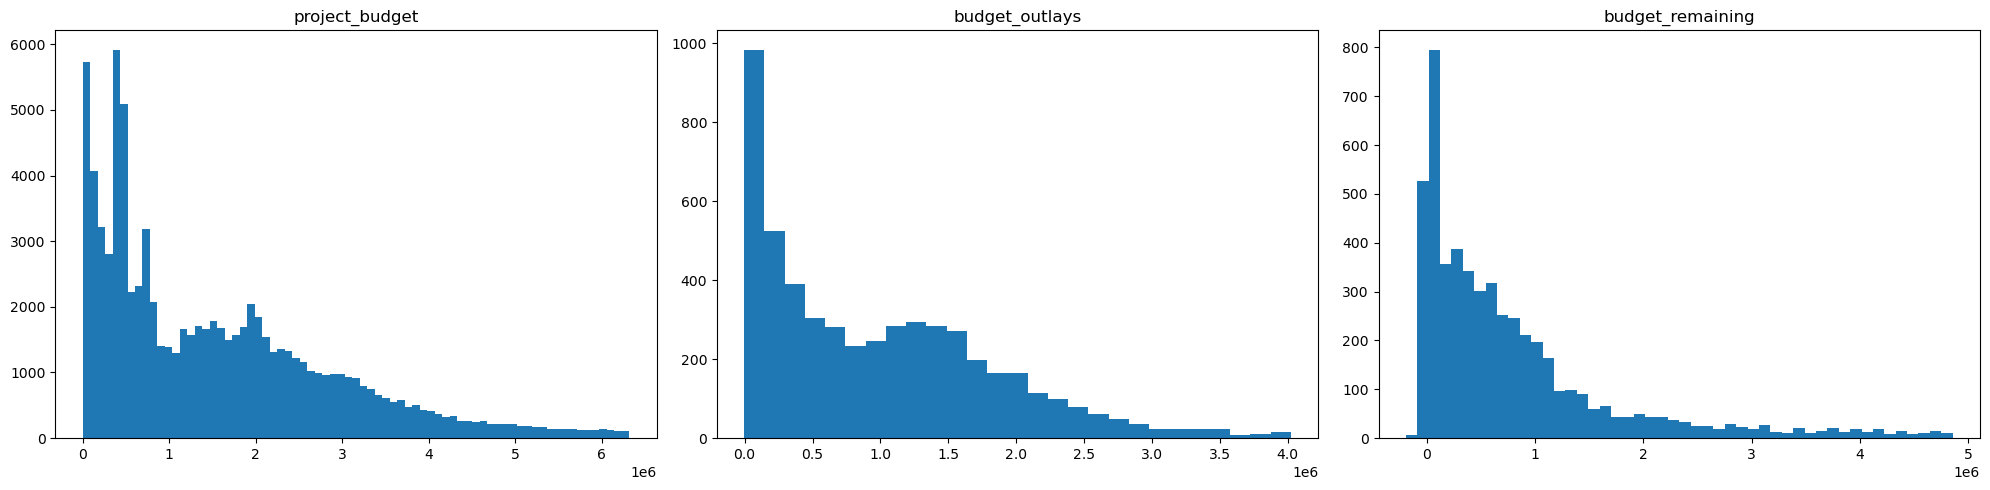

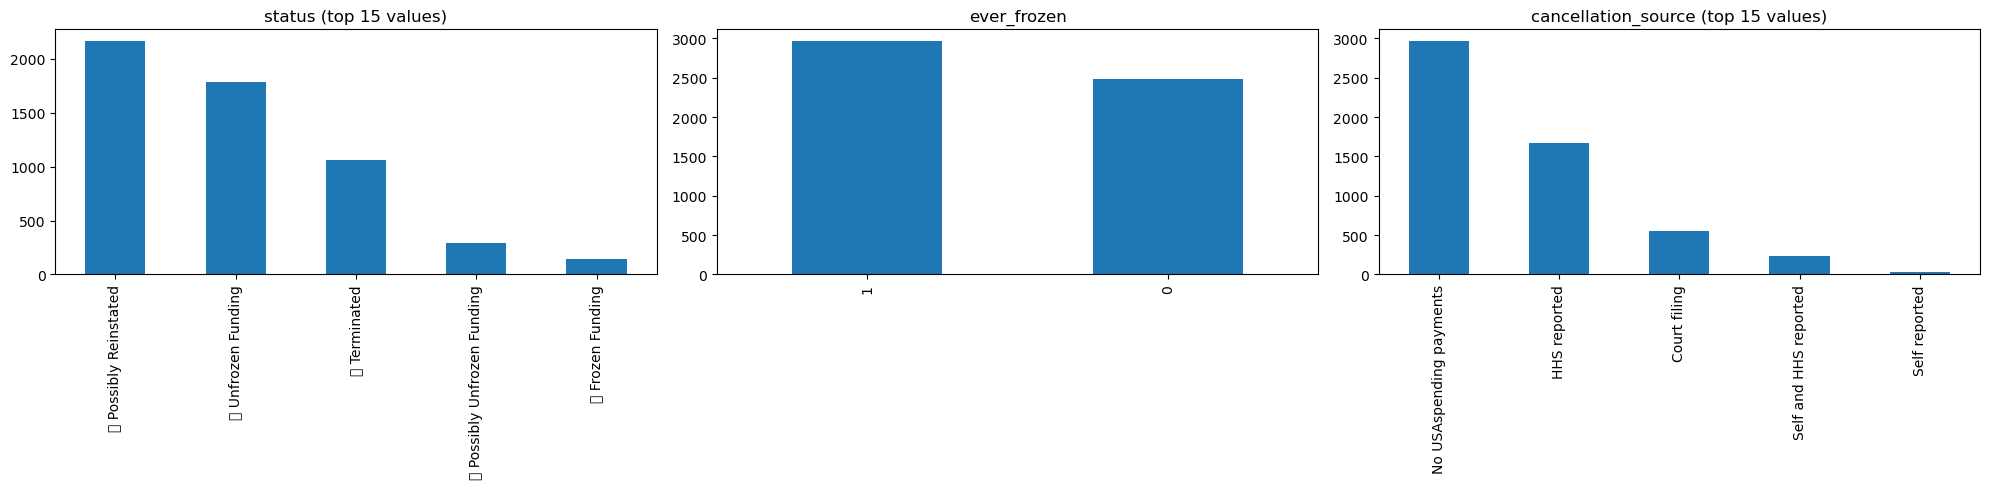

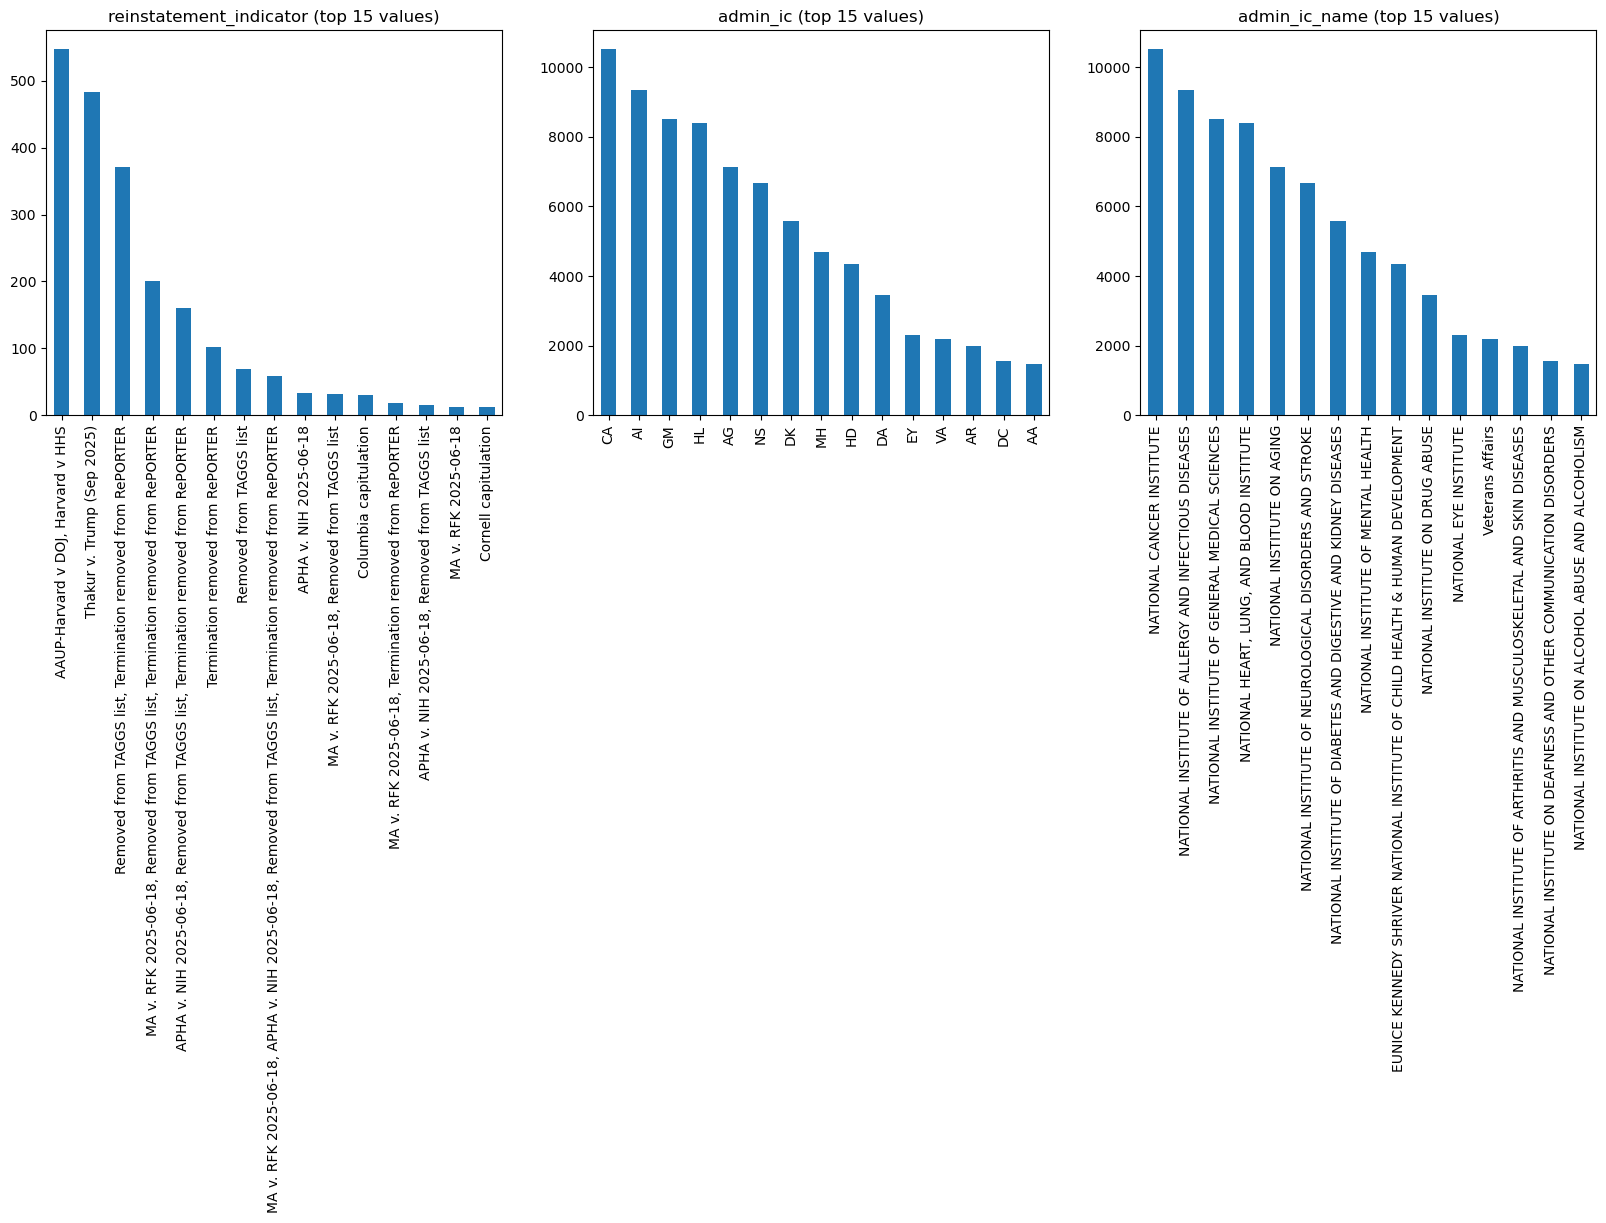

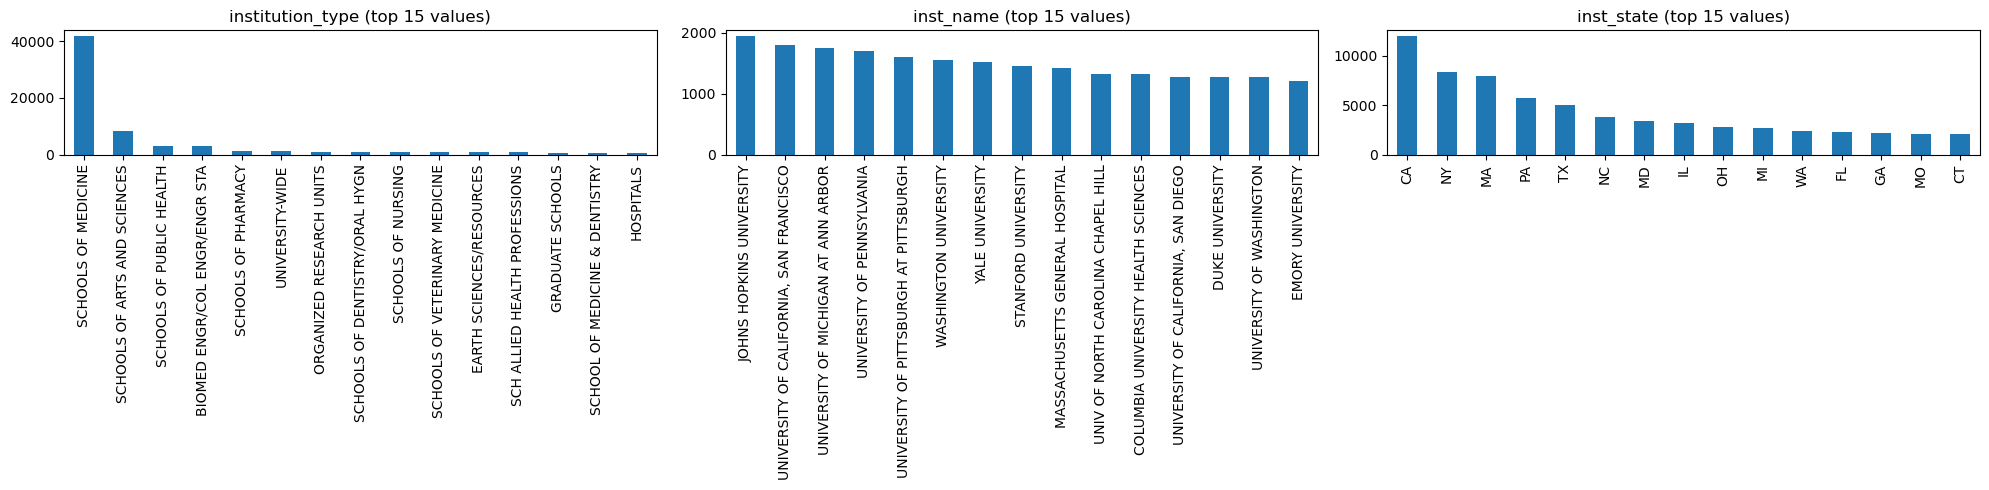

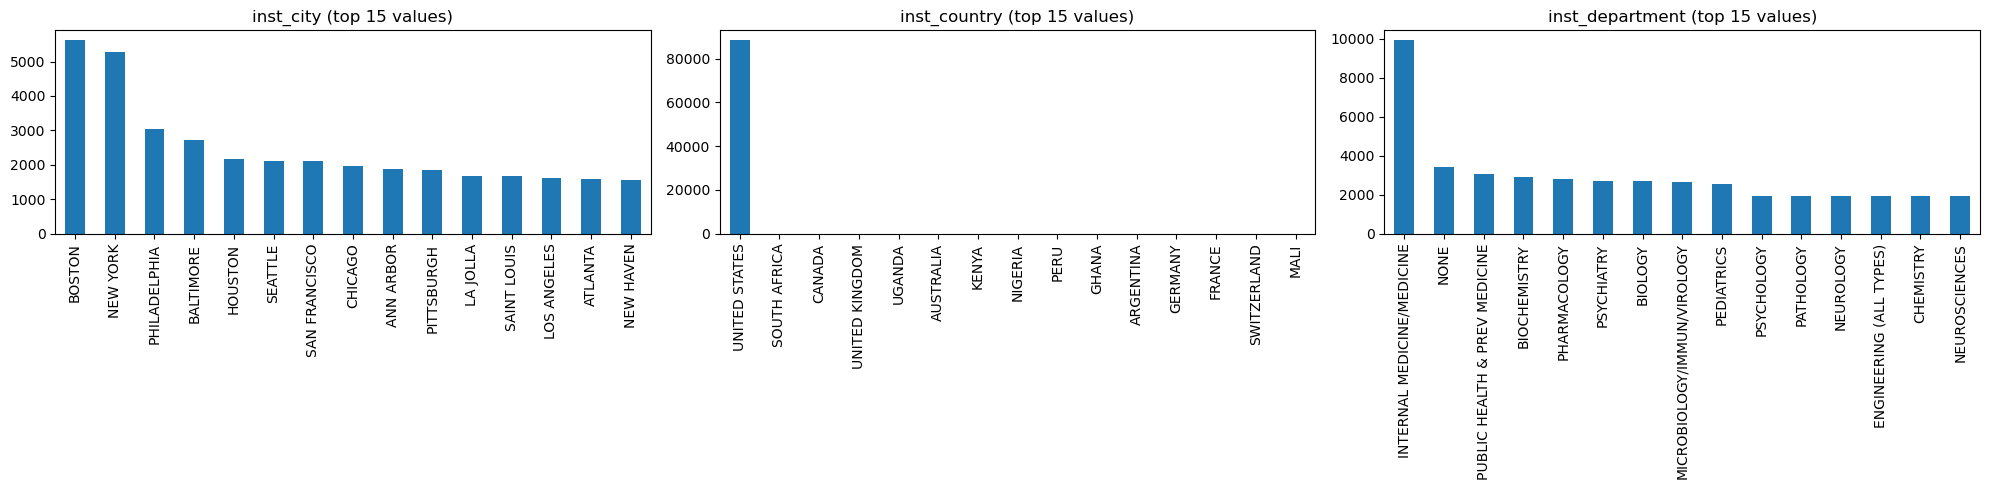

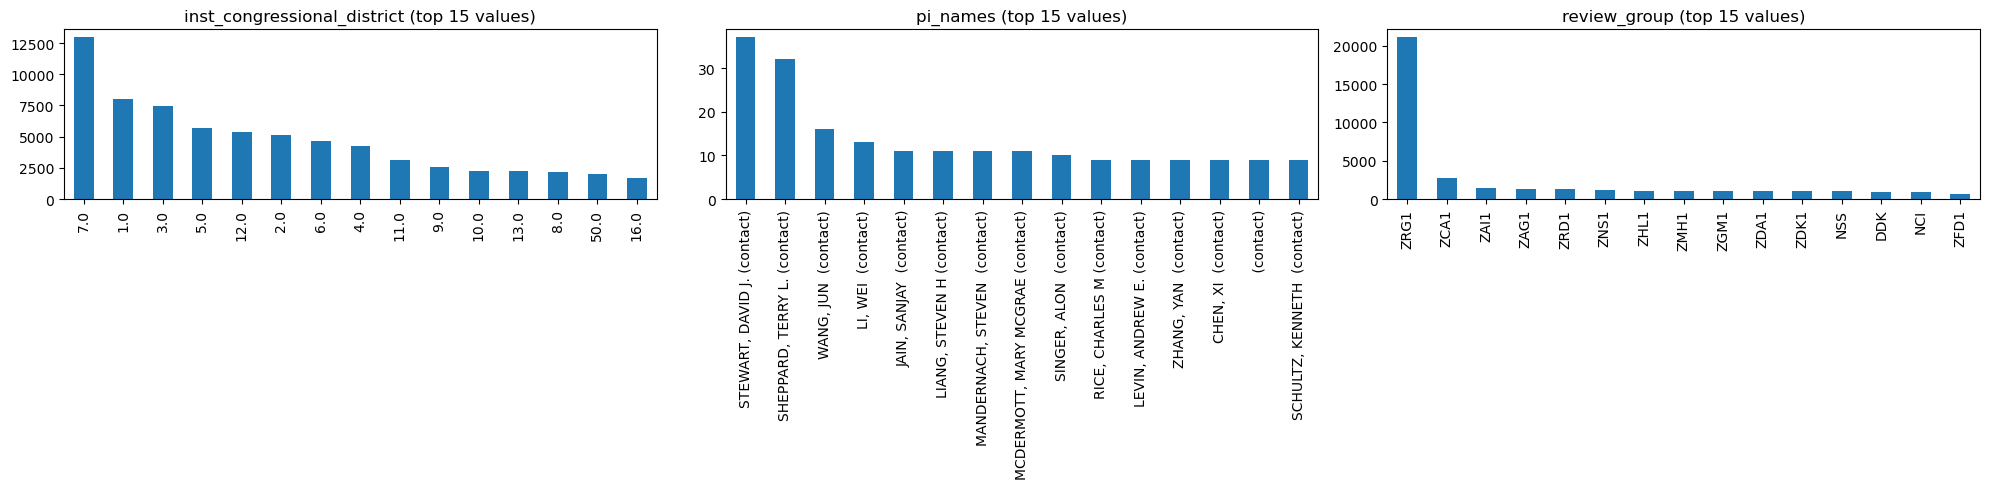

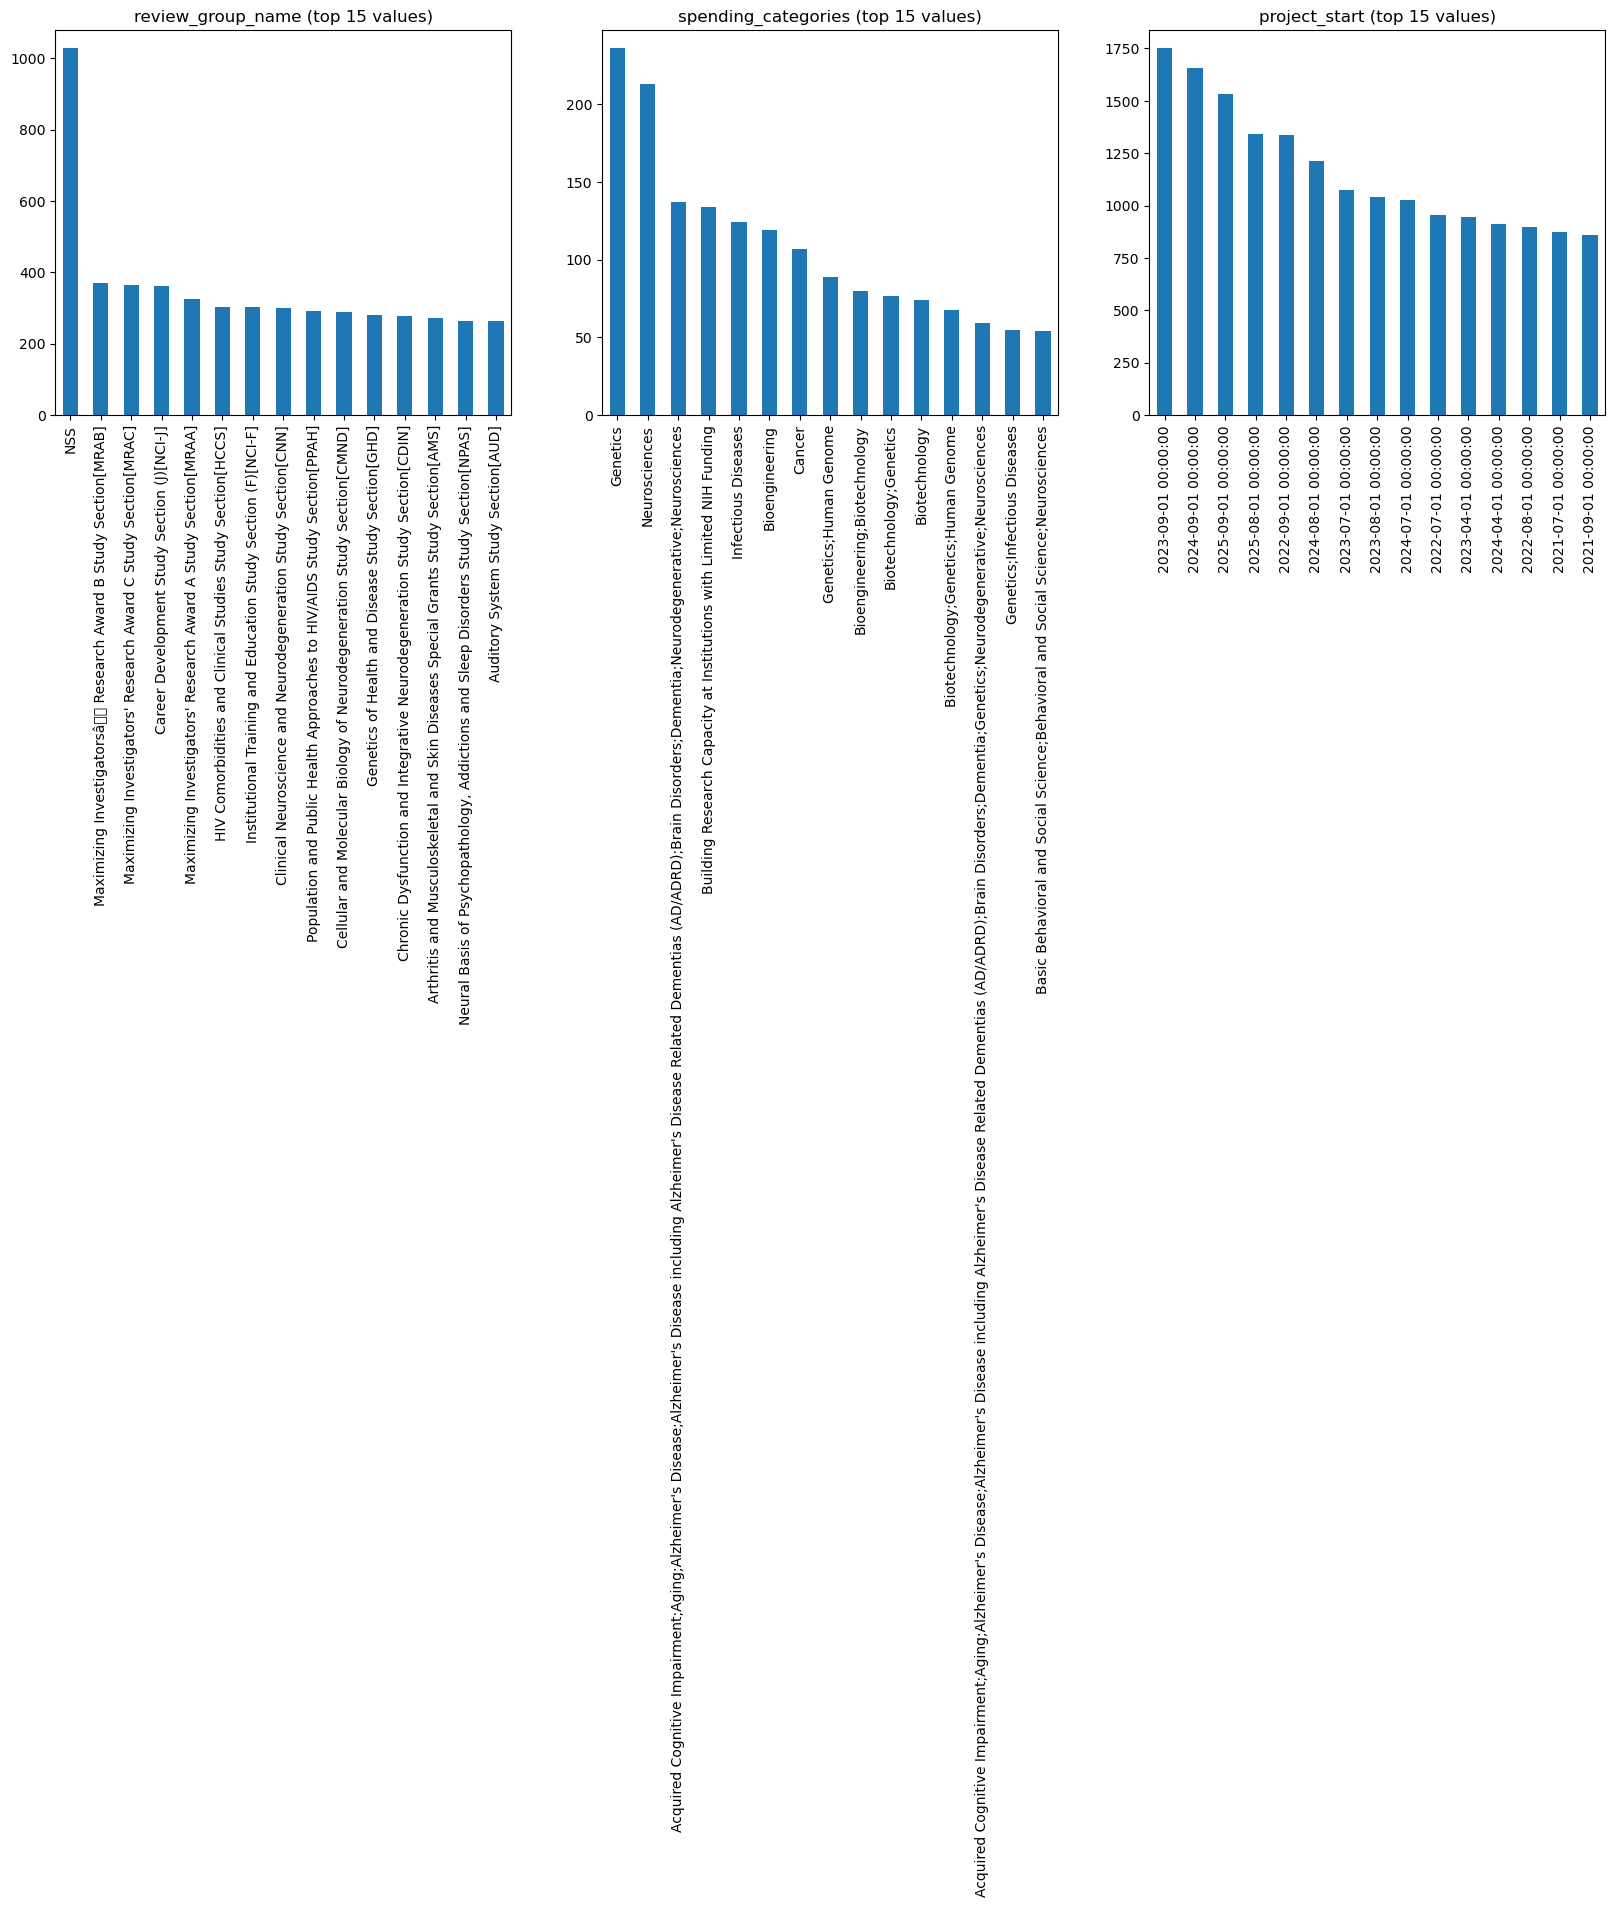

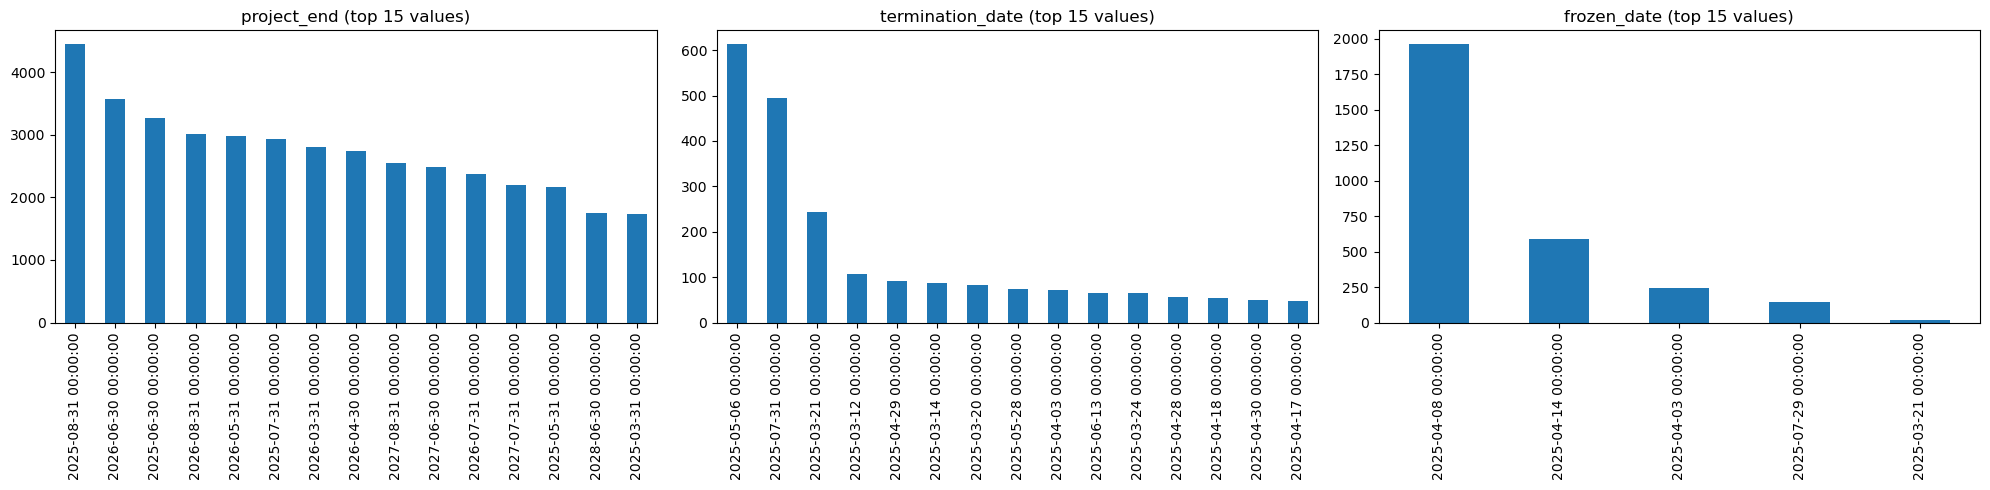

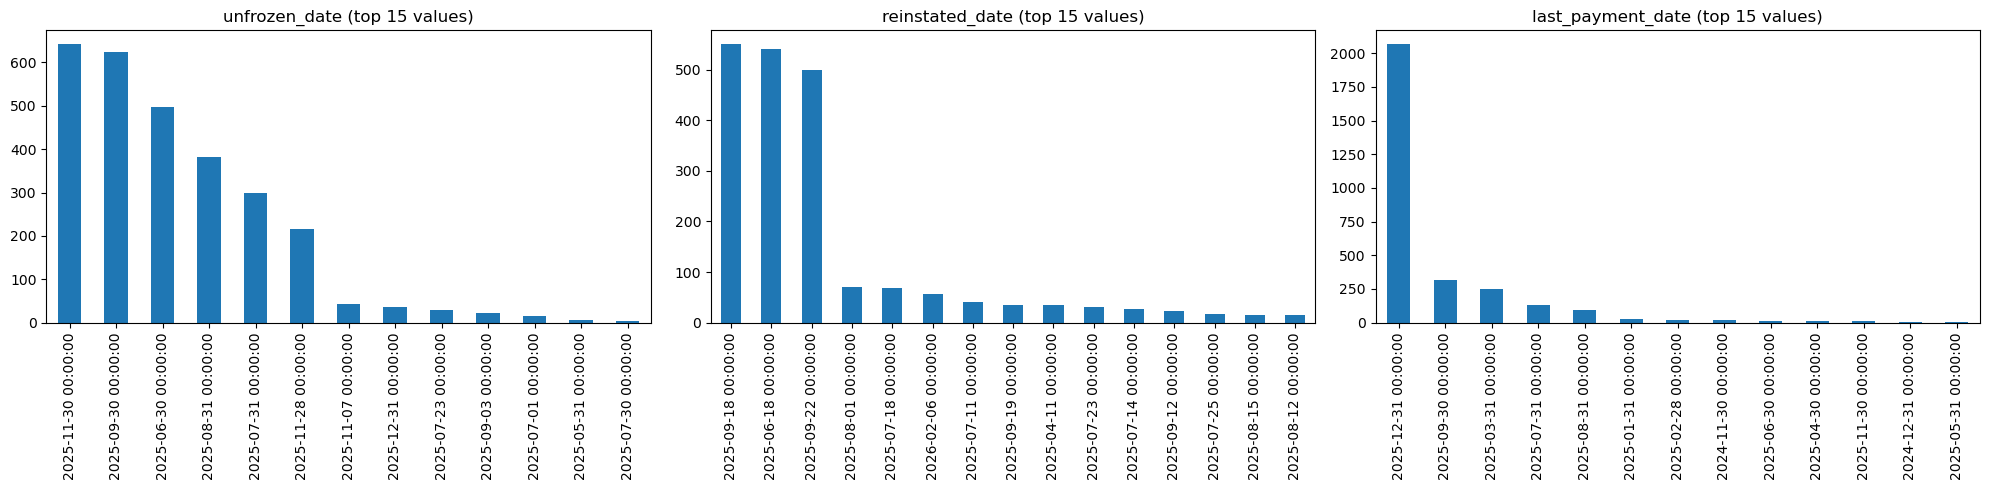

In [189]:
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

plot_features(nih, nih_summary, figsize=(20, 5), categorical_cols=[
    # STATUS
    ('status', 'status'),
    ('status', 'ever_frozen'),
    ('status', 'cancellation_source'),
    ('status', 'reinstatement_indicator'),

    # CONTEXT
    ('context', 'admin_ic'),
    ('context', 'admin_ic_name'),
    ('context', 'institution_type'),
    ('context', 'inst_name'),
    ('context', 'inst_state'),
    ('context', 'inst_city'),
    ('context', 'inst_country'),
    ('context', 'inst_department'),
    ('context', 'inst_congressional_district'),
    ('context', 'pi_names'),
    ('context', 'review_group'),
    ('context', 'review_group_name'),
    ('context', 'spending_categories'),

    # TIME (als kategoriale Plots oft sinnvoll für Verteilungen nach Jahren/Monaten)
    ('time', 'project_start'),
    ('time', 'project_end'),
    ('time', 'termination_date'),
    ('time', 'frozen_date'),
    ('time', 'unfrozen_date'),
    ('time', 'reinstated_date'),
    ('time', 'last_payment_date')
])

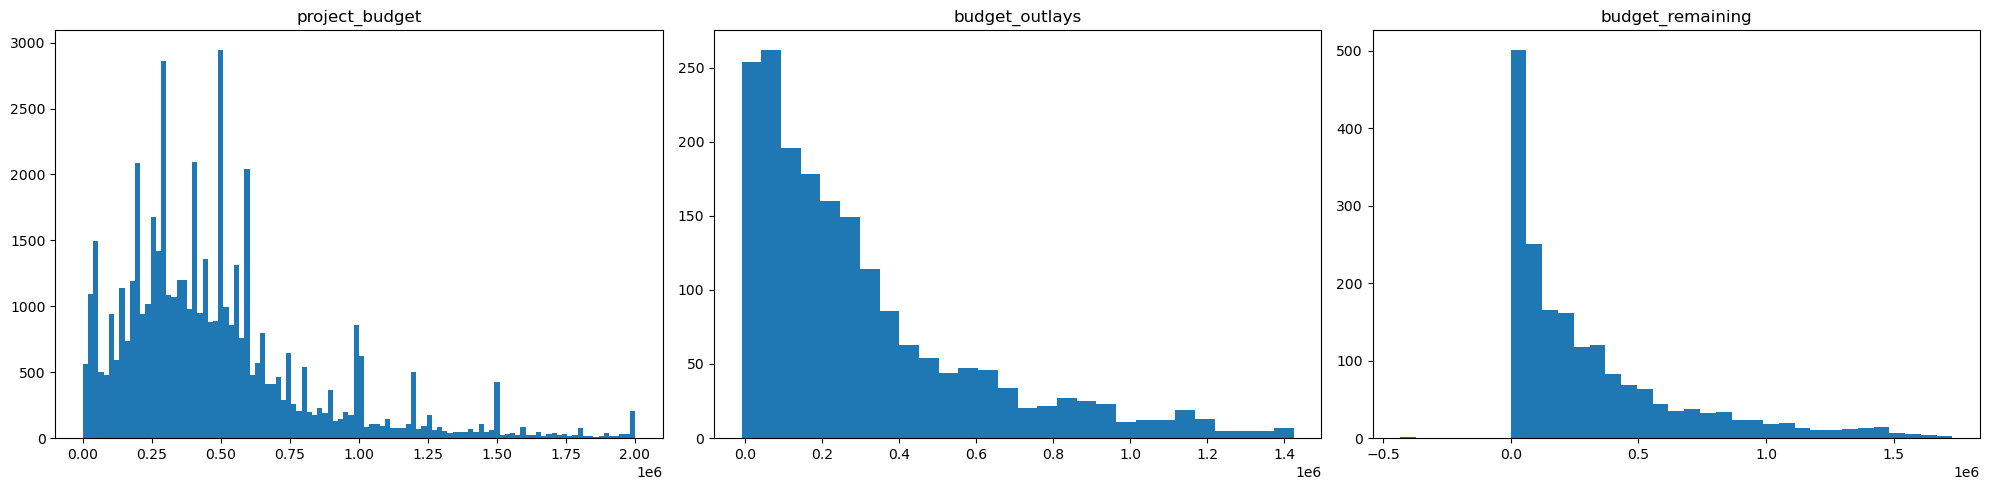

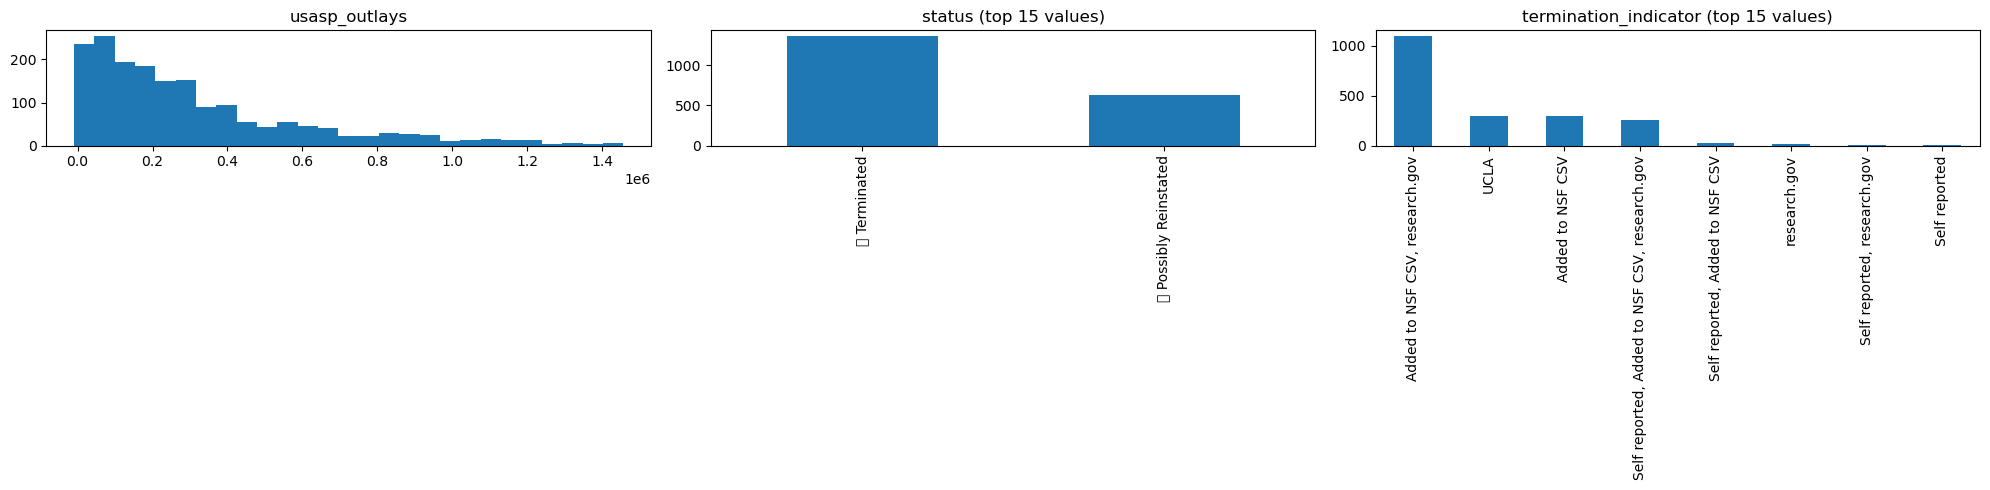

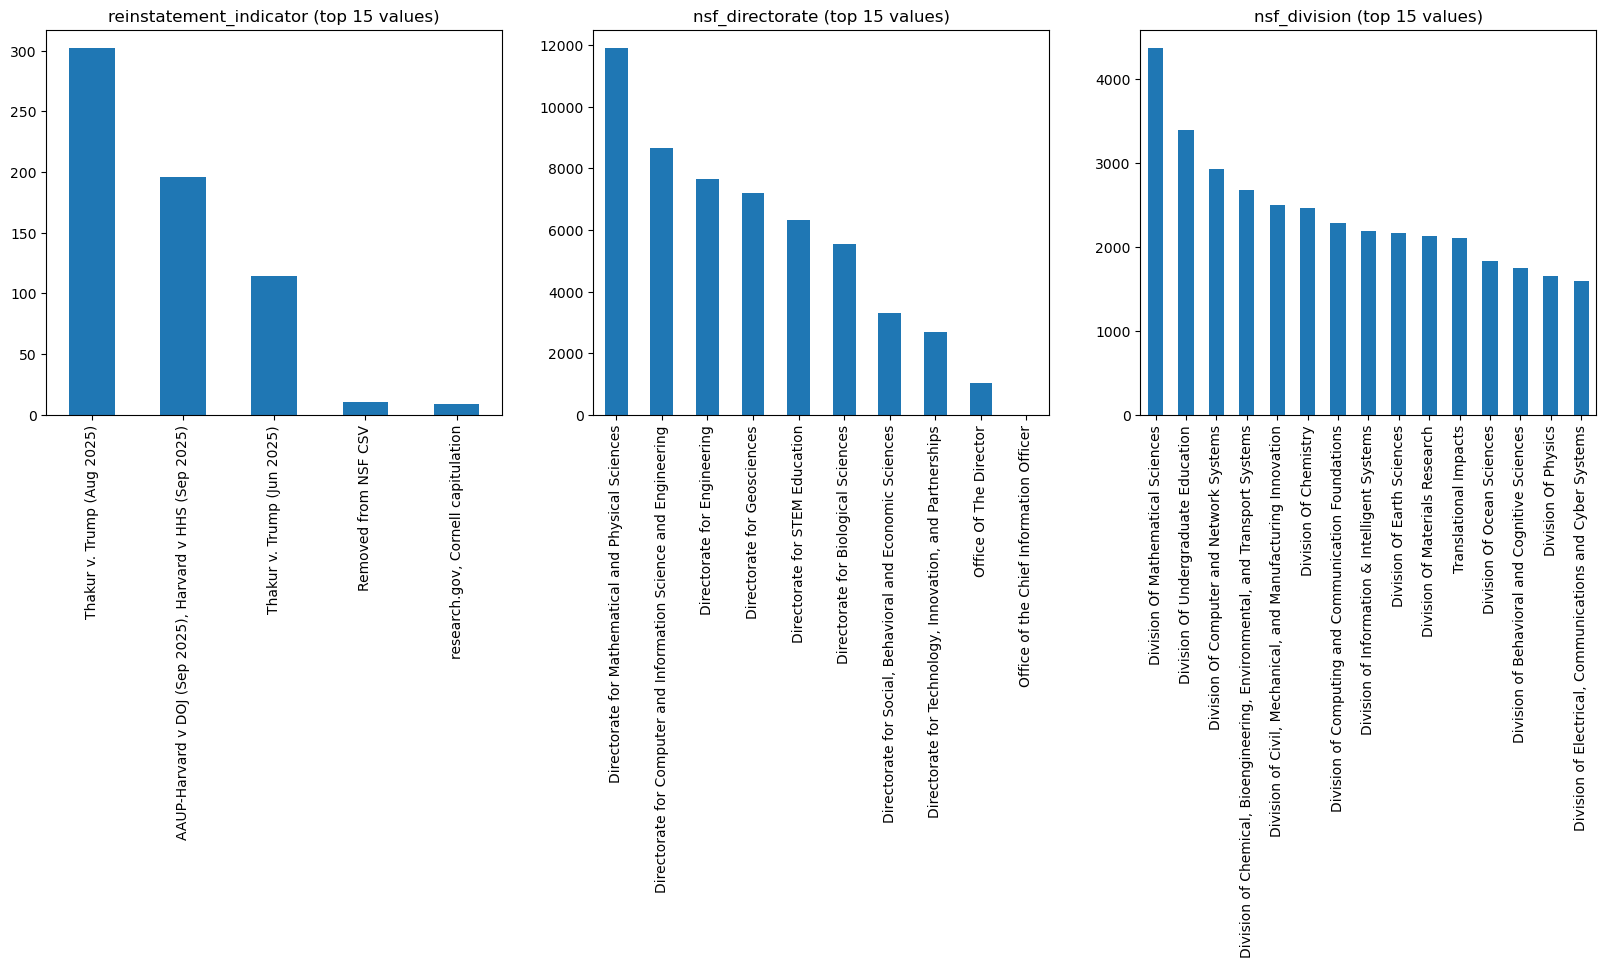

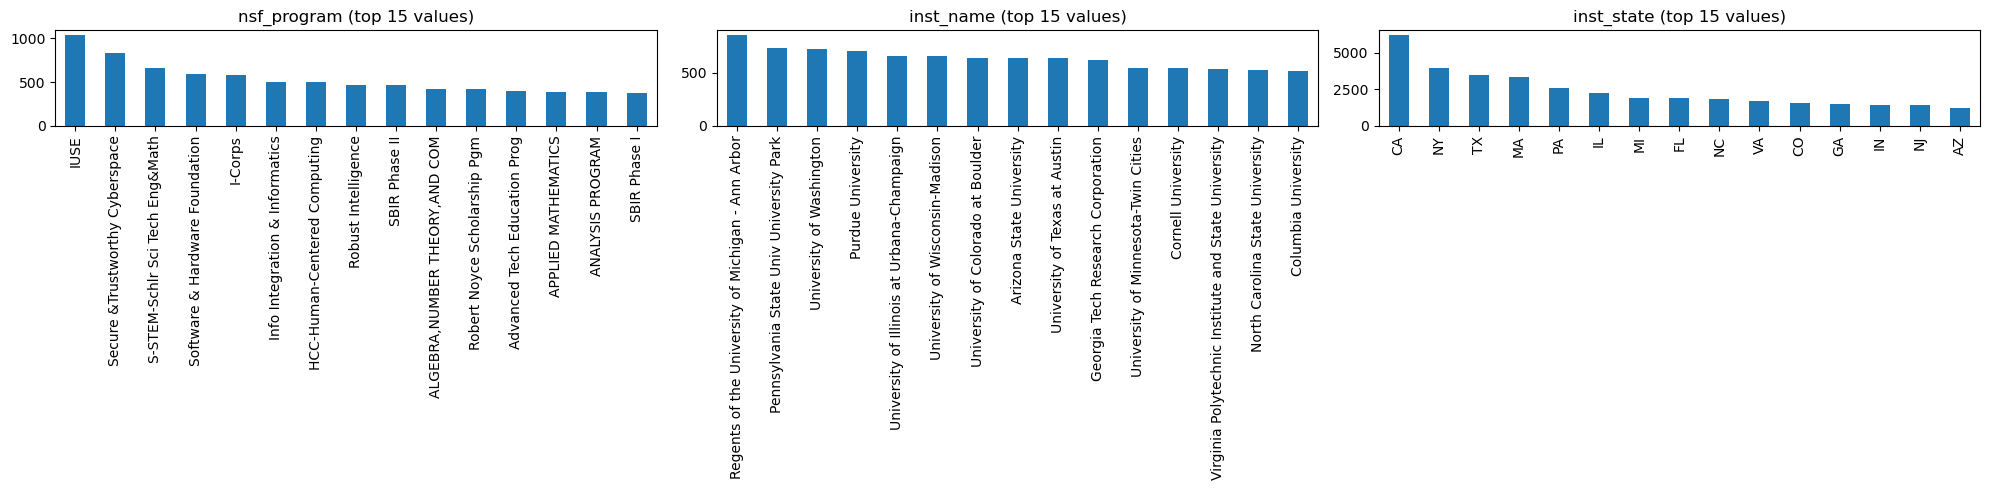

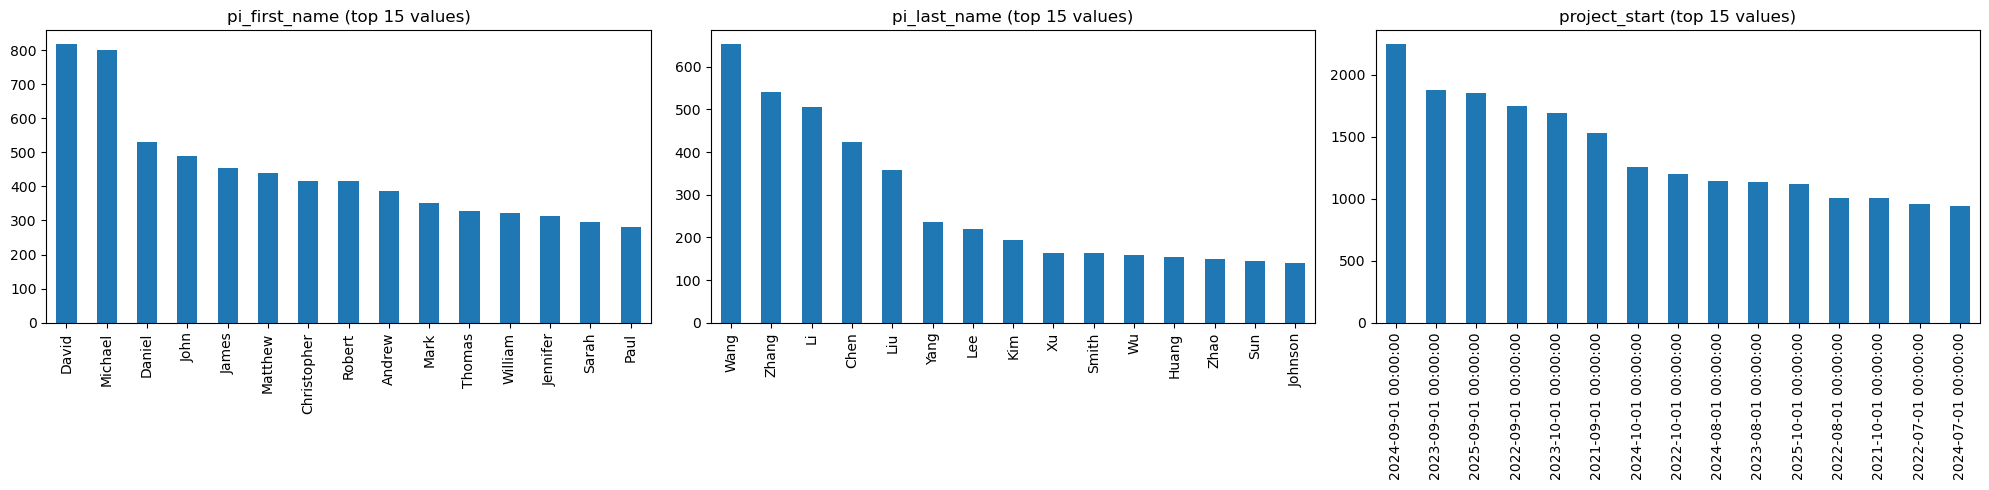

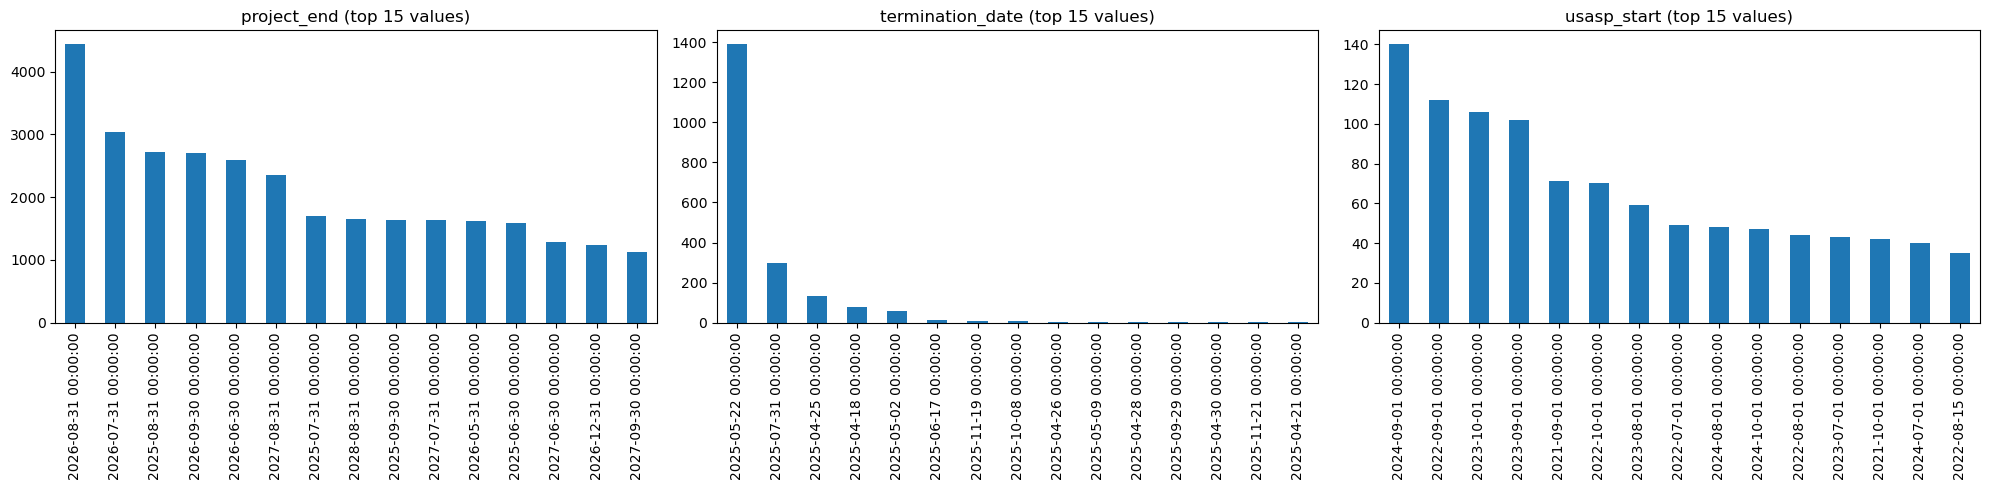

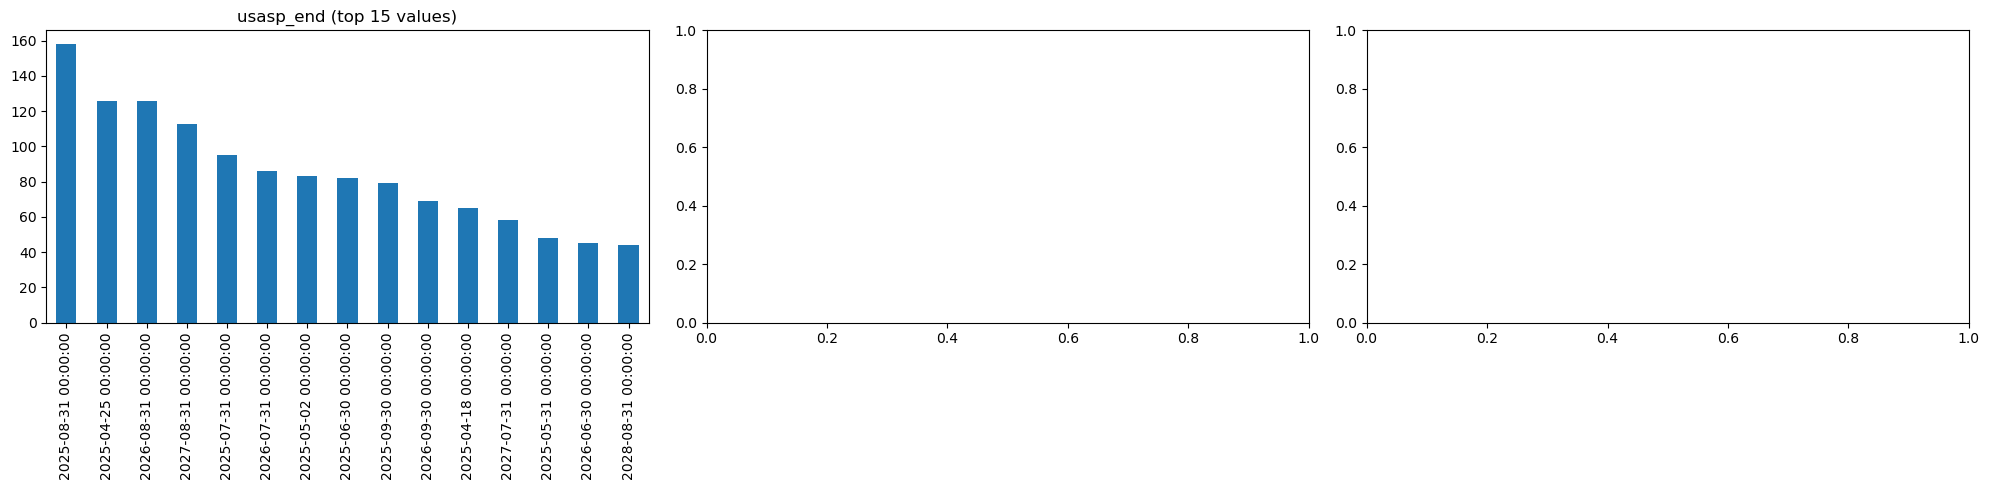

In [97]:
plot_features(nsf, nsf_summary, figsize=(20, 5), categorical_cols=[
    # STATUS
    ('status', 'status'),
    ('status', 'termination_indicator'),
    ('status', 'reinstatement_indicator'),

    # CONTEXT
    ('context', 'nsf_directorate'),
    ('context', 'nsf_division'),
    ('context', 'nsf_program'),
    ('context', 'inst_name'),
    ('context', 'inst_state'),
    ('context', 'pi_first_name'),
    ('context', 'pi_last_name'),

    # TIME
    ('time', 'project_start'),
    ('time', 'project_end'),
    ('time', 'termination_date'),
    ('time', 'usasp_start'),
    ('time', 'usasp_end'),
])

### 2.5 Source-Specific Data Quality Checks

#### Reliability of project budget information

In [298]:
def fin_check(data, outlays_col='budget_outlays'):
    data[('finance', 'check_sum')] = data[('finance', outlays_col)] + data[('finance', 'budget_remaining')]
    data[('finance', 'check_sum / project_budget')] = data[('finance', 'check_sum')] / data[('finance', 'project_budget')]

    cost = data[('finance', 'project_budget')]
    check = data[('finance', 'check_sum')]

    total_cost_false = len(data[cost != check]['finance'])
    total_cost_correct = len(data[cost == check]['finance'])

    grant_witness_mask = data[('status', 'status')].notna()
    missing_fin_inf_mask = (data[('finance', outlays_col)].isna() == True) | (data[('finance', 'budget_remaining')].isna() == True)
    missing_total_cost_mask = cost.isna() == True

    print(f"Total data entries: {len(data)}")
    print(f"NIH entries from grant-witness.us: {len(data[grant_witness_mask])}")
    print("----------------------------------")
    print(f"Entries without project_budget info: {sum(cost.isna())}")
    print(f"Grant-witness.us entries without project_budget info: {len(data[grant_witness_mask & (missing_total_cost_mask)])}")
    print(f"Grant-witness.us entries without further financial information: {len(data[grant_witness_mask & missing_fin_inf_mask])}")
    print("----------------------------------")
    print(f"Entries where project_budget equals sum of grant-witness.us financial info: {total_cost_correct}")
    print(f"Entries where project_budget does not equal sum of grant-witness.us financial info: {total_cost_false}")
    print("----------------------------------")
    print("----------------------------------")

    return pd.DataFrame({
        'measure': ['entries with total_cost info', 'grant-witness entries with correct total_cost info'],
        'value': [1 - (sum(cost.isna()) / len(data)), (total_cost_correct / len(data[grant_witness_mask]))]
    }), data[(grant_witness_mask) & (cost != check)]['finance']

##### For NIH data

In [299]:
summary, wrong_rows = fin_check(nih)
summary

Total data entries: 89313
NIH entries from grant-witness.us: 5453
----------------------------------
Entries without project_budget info: 0
Grant-witness.us entries without project_budget info: 0
Grant-witness.us entries without further financial information: 0
----------------------------------
Entries where project_budget equals sum of grant-witness.us financial info: 4046
Entries where project_budget does not equal sum of grant-witness.us financial info: 85267
----------------------------------
----------------------------------


,measure,value
0,entries with total_cost info,1.000000
1,grant-witness entries with correct total_cost ...,0.741977


In [300]:
wrong_rows

variable,project_budget,budget_outlays,budget_remaining,check_sum,check_sum / project_budget
48,4648254.0,1656098.00,378014.00,2034112.00,0.437608
100,6363332.0,2397423.76,3965908.59,6363332.35,1.000000
133,497992.0,320695.68,290770.68,611466.36,1.227864
137,57543345.0,3407087.94,2093741.69,5500829.63,0.095595
179,2044394.0,644763.49,2325830.51,2970594.00,1.453044
...,...,...,...,...,...
89254,2430000.0,1784720.84,645268.02,2429988.86,0.999995
89263,2347906.0,0.00,0.00,0.00,0.000000
89305,2345406.0,563853.76,3867377.76,4431231.52,1.889324
89307,8192428.0,4726329.15,3304341.69,8030670.84,0.980255


In [302]:
wrong_rows['check_sum / project_budget'].mean()

np.float64(0.9438924025739263)

For the rows where the sum of outlays and remaining budget by grant-whitness.us does not match the aggregated total project budget: <br>
- On average the grant-whitness.us sum is only slightly smaller than the aggregated NIH project budget. Since grant-whitness.us uses a slightly more sophisticated approach to calculate the total project budget, a reasonable imputation strategy would be to simply copy the grant-whitness.us budget sum and use it as project_budget if this budget sum is not NAN or 0.
- Wherever the budget sum is 0, we can assume the remaining budget to be the total project budget

In [303]:
nih[('finance', 'project_budget')] = np.where(
    (nih[('finance', 'check_sum')] != 0) & (nih[('finance', 'check_sum')].notna()), 
    nih[('finance', 'check_sum')], 
    nih[('finance', 'project_budget')]
)

nih[('finance', 'budget_remaining')] = np.where(
    (nih[('finance', 'check_sum')] == 0), 
    nih[('finance', 'project_budget')], 
    nih[('finance', 'budget_remaining')]
)

In [304]:
summary, wrong_rows = fin_check(nih)
summary

Total data entries: 89313
NIH entries from grant-witness.us: 5453
----------------------------------
Entries without project_budget info: 0
Grant-witness.us entries without project_budget info: 0
Grant-witness.us entries without further financial information: 0
----------------------------------
Entries where project_budget equals sum of grant-witness.us financial info: 5453
Entries where project_budget does not equal sum of grant-witness.us financial info: 83860
----------------------------------
----------------------------------


,measure,value
0,entries with total_cost info,1.0
1,grant-witness entries with correct total_cost ...,1.0


In [323]:
nih = nih.drop([('finance', 'check_sum'), ('finance', 'check_sum / project_budget')], axis=1)

##### For NSF data

In [305]:
summary, wrong_rows = fin_check(nsf, outlays_col='usasp_outlays')
summary

Total data entries: 54294
NIH entries from grant-witness.us: 1995
----------------------------------
Entries without project_budget info: 0
Grant-witness.us entries without project_budget info: 0
Grant-witness.us entries without further financial information: 93
----------------------------------
Entries where project_budget equals sum of grant-witness.us financial info: 1710
Entries where project_budget does not equal sum of grant-witness.us financial info: 52584
----------------------------------
----------------------------------


,measure,value
0,entries with total_cost info,1.000000
1,grant-witness entries with correct total_cost ...,0.857143


In [306]:
summary, wrong_rows = fin_check(nsf)
summary

Total data entries: 54294
NIH entries from grant-witness.us: 1995
----------------------------------
Entries without project_budget info: 0
Grant-witness.us entries without project_budget info: 0
Grant-witness.us entries without further financial information: 2
----------------------------------
Entries where project_budget equals sum of grant-witness.us financial info: 1795
Entries where project_budget does not equal sum of grant-witness.us financial info: 52499
----------------------------------
----------------------------------


,measure,value
0,entries with total_cost info,1.000000
1,grant-witness entries with correct total_cost ...,0.899749


In [307]:
wrong_rows

variable,project_budget,budget_outlays,budget_remaining,usasp_outlays,check_sum,check_sum / project_budget
17,20672.0,NaN,NaN,NaN,NaN,NaN
86,57342.0,40223.59,17715.41,40223.59,57939.0,1.010411
2726,150978.0,48254.04,123796.96,48254.04,172051.0,1.139577
3754,575000.0,179513.30,450486.70,179513.30,630000.0,1.095652
5256,1000000.0,699999.00,500000.00,699999.00,1199999.0,1.199999
...,...,...,...,...,...,...
54195,516072.0,225114.79,388946.21,225114.79,614061.0,1.189875
54197,1137520.0,552103.44,710273.56,552103.44,1262377.0,1.109762
54216,5000000.0,2285042.51,2814957.49,2285042.51,5100000.0,1.020000
54234,850000.0,872309.27,547897.73,872309.27,1420207.0,1.670832


In [308]:
wrong_rows['check_sum / project_budget'].mean()

np.float64(1.1816972887976223)

For the rows where the sum of outlays and remaining budget by grant-whitness.us does not match the aggregated total project budget: <br>
- On average the grant-whitness.us sum is only slightly larger than the aggregated NSF project budget. Since grant-whitness.us uses a slightly more sophisticated approach to calculate the total project budget, a reasonable imputation strategy would be to simply copy the grant-whitness.us budget sum and use it as project_budget if this budget sum is not NAN or 0.
- Wherever the budget sum is 0, we can assume the remaining budget to be the total project budget

In [ ]:
nsf[('finance', 'project_budget')] = np.where(
    (nsf[('finance', 'check_sum')] != 0) & (nsf[('finance', 'check_sum')].notna()), 
    nsf[('finance', 'check_sum')], 
    nsf[('finance', 'project_budget')]
)

nsf[('finance', 'budget_remaining')] = np.where(
    ((nsf[('finance', 'check_sum')] == 0)), 
    nsf[('finance', 'project_budget')], 
    nsf[('finance', 'budget_remaining')]
)

# all grant-whitness entries with NAN at outlays and remaining budget are filled with 0 and total project budget
mask = (nsf[('status', 'status')].notna()) & (nsf[('finance', 'check_sum')].isna())
nsf.loc[mask, ('finance', 'budget_remaining')] = nsf.loc[mask, ('finance', 'project_budget')]
nsf.loc[mask, ('finance', 'budget_outlays')] = 0

In [320]:
summary, wrong_rows = fin_check(nsf)
summary

Total data entries: 54294
NIH entries from grant-witness.us: 1995
----------------------------------
Entries without project_budget info: 0
Grant-witness.us entries without project_budget info: 0
Grant-witness.us entries without further financial information: 0
----------------------------------
Entries where project_budget equals sum of grant-witness.us financial info: 1995
Entries where project_budget does not equal sum of grant-witness.us financial info: 52299
----------------------------------
----------------------------------


,measure,value
0,entries with total_cost info,1.0
1,grant-witness entries with correct total_cost ...,1.0


In [324]:
nsf = nsf.drop([('finance', 'check_sum'), ('finance', 'check_sum / project_budget')], axis=1)

### 2.7 Save total dataset

In [98]:
nih[('id', 'data_source')] = 'NIH'
nsf[('id', 'data_source')] = 'NSF'

In [ ]:
common_cols = list(set(nih.columns.values).intersection(set(nsf.columns.values)))
common_cols

[('status', 'status'),
 ('finance', 'project_budget'),
 ('finance', 'budget_outlays'),
 ('time', 'termination_date'),
 ('status', 'reinstatement_indicator'),
 ('context', 'inst_name'),
 ('content', 'title'),
 ('id', 'data_source'),
 ('finance', 'budget_remaining'),
 ('id', 'id'),
 ('context', 'inst_state'),
 ('time', 'project_start'),
 ('content', 'abstract'),
 ('time', 'project_end')]

In [102]:
data = pd.concat([nih[common_cols + [('context', 'pi_names')]], nsf[common_cols + [('context', 'pi_first_name'), ('context', 'pi_last_name')]]], axis=0)

category_order = ['id', 'status', 'context', 'time', 'finance', 'content']
data = data.reindex(columns=category_order, level='category')

data.to_parquet('project_population_at_risk.parquet')

### 2.8 Common Data Quality Checks

In [194]:
data = pd.read_parquet('project_population_at_risk.parquet')

In [104]:
data_summary = feature_summary(data)
data_summary

,category,variable,datatype,missing_val_count,missing_val_pct,existing_val_count,distinct_val_count,mode,mean,std,q25,median,q75,outliers
0,id,data_source,object,0.0,0.000000,143607.0,2.0,NIH,NaN,NaN,NaN,NaN,NaN,NaN
0,id,id,string[python],0.0,0.000000,143607.0,143607.0,"[1202910, 1326927, 1400450, 1419935, 1421197, ...",NaN,NaN,NaN,NaN,NaN,NaN
0,status,status,string[python],136159.0,0.948136,7448.0,5.0,🔄 Possibly Reinstated,NaN,NaN,NaN,NaN,NaN,NaN
0,status,reinstatement_indicator,string[python],140799.0,0.980447,2808.0,33.0,"AAUP-Harvard v DOJ, Harvard v HHS",NaN,NaN,NaN,NaN,NaN,NaN
0,context,pi_first_name,string[python],89313.0,0.621927,54294.0,10957.0,David,NaN,NaN,NaN,NaN,NaN,NaN
0,context,pi_names,string[python],54382.0,0.378686,89225.0,70670.0,"STEWART, DAVID J. (contact)",NaN,NaN,NaN,NaN,NaN,NaN
0,context,pi_last_name,string[python],89313.0,0.621927,54294.0,21432.0,Wang,NaN,NaN,NaN,NaN,NaN,NaN
0,context,inst_name,string[python],71.0,0.000494,143536.0,8088.0,JOHNS HOPKINS UNIVERSITY,NaN,NaN,NaN,NaN,NaN,NaN
0,context,inst_state,string[python],762.0,0.005306,142845.0,65.0,CA,NaN,NaN,NaN,NaN,NaN,NaN
0,time,termination_date,datetime64[ns],138377.0,0.963581,5230.0,136.0,2025-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Preparation

### 3.1 Enriching the Dataset

#### 3.1.1 Scientific Topic Inference

##### BERT-Based OpenAlex Topic Inference

In [ ]:
if not os.path.exists('topics.parquet'):
    from transformers import pipeline
    from tqdm.auto import tqdm

    # specifying model pipeline
    classifier = pipeline(
        model="OpenAlex/bert-base-multilingual-cased-finetuned-openalex-topic-classification-title-abstract", 
        top_k=10, 
        truncation=True, 
        max_length=512,
        device=0 
    )

    # insert title and abstract into a common string
    def prepare_text(row):
        title = "" if pd.isna(row[('content', 'title')]) else row[('content', 'title')]
        abstract = "" if pd.isna(row[('content', 'abstract')]) else row[('content', 'abstract')]
        if title == "" and abstract == "":
            return None
        return f"<TITLE> {title}\n<ABSTRACT> {abstract}"

    texts = [prepare_text(row) for _, row in data.iterrows()]

    def data_generator(text_list):
        for text in text_list:
            if text is not None:
                yield text
            else:
                yield ""

    # inference
    batch_size = 16
    results = []
    for out in tqdm(classifier(data_generator(texts), batch_size=batch_size), total=len(texts)):
        results.append(out[0] if out else np.nan)

    # save results
    topics = pd.DataFrame({
        'id': data[('id', 'id')].values,
        'topic': results
    })
    topics.to_parquet('topics.parquet')
    
else:
    topics = pd.read_parquet('topics.parquet')

In [ ]:
# add inferred topics to data frame
topics.columns = pd.MultiIndex.from_tuples([
    ('id', 'id'),
    ('sci_class', 'topic')
])
data = data.merge(topics, on=[('id', 'id')], how='left')

##### Add OpenAlex Topic Hierarchy

The OpenAlex Topic Taxonomy can be found [here](https://docs.google.com/spreadsheets/d/1v-MAq64x4YjhO7RWcB-yrKV5D_2vOOsxl4u6GBKEXY8/edit?usp=sharing). We download this file as csv and store it in the main directory of this project as `openalex-topic-mapping.csv`

In [ ]:
def split_topic(val):
    if not isinstance(val, dict) or 'label' not in val:
        return pd.Series([np.nan, np.nan])
    
    label_str = val['label']
    
    try:
        raw_id, _ , topic_name = label_str.partition(': ')
        topic_id_fixed = str(int(raw_id) + 10000)
        
        return pd.Series([topic_id_fixed, topic_name])
    
    except Exception:
        return pd.Series([np.nan, np.nan])

# splitting inferred topic into topic_id and topic_name
data[[('sci_class', 'topic_id'), ('sci_class', 'topic_name')]] = data[('sci_class', 'topic')].apply(split_topic)

# enriching topic with subfield, field and domain information
topic_map = pd.read_csv('openalex-topic-mapping.csv')
topic_map['topic_id'] = topic_map['topic_id'].astype(str)
data[('sci_class', 'topic_id')] = data[('sci_class', 'topic_id')].astype(str)
mapping_columns = ['topic_id', 'subfield_id', 'subfield_name', 'field_id', 'field_name', 'domain_id', 'domain_name']
topic_map_subset = topic_map[mapping_columns].copy()
topic_map_subset.columns = pd.MultiIndex.from_tuples([('sci_class', col) for col in mapping_columns])
data = data.merge(topic_map_subset, on=[('sci_class', 'topic_id')], how='left')

if ('sci_class', 'topic') in data.columns:
    data = data.drop(columns=[('sci_class', 'topic')])

In [205]:
data[['content', 'sci_class']]

content  \
                                                    title   
0       Linking Daily Parental PACEs to Parenting and ...   
1                    COBRE in Digestive and Liver Disease   
2       KSHV immortalization of human lymphatic endoth...   
3       Impact of neuromelanin and Tau accumulation du...   
4       Developing Tools to Probe DnaJB6 Dynamics in S...   
...                                                   ...   
143602  Tuskegee University is leading a team of Alaba...   
143603  Tuskegee University is leading a team of Alaba...   
143604  The S-STEM project "STEM Scholarship Program w...   
143605  To enable a world-wide multi-user community to...   
143606  To enable a world-wide multi-user community to...   

                                                          sci_class  \
                                                 abstract  topic_id   
0       Parental adverse childhood experiences (ACEs) ...     10182   
1       Overall â Project Summary\nThe overall goal ...     12168   
2       Abstract:\nOpportunistic infections are a majo...     11668   
3       PROJECT SUMMARY\nThe locus coeruleus (LC) is a...     11289   
4       PROJECT SUMMARY/ABSTRACT\n Spinobulbar Muscula...     10949   
...                                                   ...       ...   
143602  Collaborative Research: Making to Advance Know...     10726   
143603  Collaborative Research: Making to Advance Know...     10726   
143604  STEM Scholarship Program with Promotion and Re...     10726   
143605  Atacama Large Millimeter/submillimeter Array (...     12450   
143606  National Radio Astronomy Observatory: Operatio...     12450   

                                                                       \
                                               topic_name subfield_id   
0       Emotion Regulation and Psychopathology in Chil...      3203.0   
1       Challenges and Opportunities in Translational ...      2739.0   
2                      Innate Immunity to Viral Infection      2403.0   
3       Comprehensive Integration of Single-Cell Trans...      1312.0   
4       Molecular Mechanisms of Neurodegenerative Dise...      2804.0   
...                                                   ...         ...   
143602      Social Cognitive Theory in Career Development      3311.0   
143603      Social Cognitive Theory in Career Development      3311.0   
143604      Social Cognitive Theory in Career Development      3311.0   
143605  Advancements in Radio Astronomy Techniques and...      3103.0   
143606  Advancements in Radio Astronomy Techniques and...      3103.0   

                                                                    \
                                            subfield_name field_id   
0                                     Clinical Psychology     32.0   
1       Public Health, Environmental and Occupational ...     27.0   
2                                              Immunology     24.0   
3                                       Molecular Biology     13.0   
4                     Cellular and Molecular Neuroscience     28.0   
...                                                   ...      ...   
143602                                    Safety Research     33.0   
143603                                    Safety Research     33.0   
143604                                    Safety Research     33.0   
143605                         Astronomy and Astrophysics     31.0   
143606                         Astronomy and Astrophysics     31.0   

                                                                \
                                          field_name domain_id   
0                                         Psychology       2.0   
1                                           Medicine       4.0   
2                        Immunology and Microbiology       1.0   
3       Biochemistry, Genetics and Molecular Biology       1.0   
4                                       Neuroscience       1.0   
...      

#### 3.1.2 Political Party Affiliation of Federal State

In [206]:
# Majority of electoral votes per state for 2024 presidential election
# source: https://apnews.com/projects/election-results-2024/

election_data = {
    "State": [
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", 
        "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", 
        "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", 
        "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", 
        "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ],
    "Party": [
        "R", "R", "R", "R", "D", "D", "D", "D", "D", "R",
        "R", "D", "R", "D", "R", "R", "R", "R", "R", "D",
        "D", "D", "R", "D", "R", "R", "R", "R", "R", "D",
        "D", "D", "D", "R", "R", "R", "R", "D", "R", "D",
        "R", "R", "R", "R", "R", "D", "D", "D", "R", "R", "R"
    ]
}

df_electoral_2024 = pd.DataFrame(election_data)
party_map = dict(zip(df_electoral_2024.State, df_electoral_2024.Party))
data[('context', 'party_affiliation')] = data[('context', 'inst_state')].str.strip().map(party_map)

#### 3.1.3 Inferring Gender From PI-Name

##### Extract First- and Lastname from NIH Formatting

In [207]:
mask = data[('id', 'data_source')] == 'NIH'

# extract first PI
temp_names = data.loc[mask, ('context', 'pi_names')].str.split(';').str[0]
# remove '(contact)' indication
temp_names = temp_names.str.replace(r'\(contact\)', '', regex=True).str.strip()
# split first and last name
split_names = temp_names.str.split(',', n=1, expand=True)

data.loc[mask, ('context', 'pi_last_name')] = split_names[0].str.strip().str.title()
data.loc[mask, ('context', 'pi_first_name')] = split_names[1].str.strip().str.title()

data = data.drop(('context', 'pi_names'), axis=1)

##### Stage 1: GenderGuesser
(should work well for "standard western names")

In [208]:
import gender_guesser.detector as gender

d = gender.Detector(case_sensitive=False)

def predict_gender(name):
    if not isinstance(name, str) or len(name) < 2:
        return 'unknown'
    
    clean_name = name.split()[0].replace('-', '') 
    guess = d.get_gender(clean_name)
    return guess

print("Start gender inference...")
data[('context', 'gender_raw')] = data[('context', 'pi_first_name')].apply(predict_gender)

gender_map = {
    'male': 'male',
    'female': 'female',
    'mostly_male': 'male',
    'mostly_female': 'female',
    'andy': 'unisex',
    'unknown': 'unknown'
}

data[('context', 'gender_inferred')] = data[('context', 'gender_raw')].map(gender_map)

print("-" * 30)
print(data[('context', 'gender_inferred')].value_counts(normalize=True))
print("-" * 30)

Start gender inference...
------------------------------
(context, gender_inferred)
male       0.475485
female     0.312255
unknown    0.122578
unisex     0.089682
Name: proportion, dtype: float64
------------------------------


In [209]:
data[(data[('context', 'gender_inferred')] == 'unisex') | (data[('context', 'gender_inferred')] == 'unknown')]['context']

,inst_name,inst_state,pi_first_name,pi_last_name,party_affiliation,gender_raw,gender_inferred
8,DUKE UNIVERSITY,NC,Jiaoti,Huang,R,unknown,unknown
9,MICHIGAN STATE UNIVERSITY,MI,Kin Sing Stephen,Lee,R,andy,unisex
13,UNIVERSITY OF IOWA,IA,Mathews,Jacob,R,unknown,unknown
23,OHIO STATE UNIVERSITY,OH,Rajendar K,Deora,R,unknown,unknown
37,EMORY UNIVERSITY,GA,Baek,Kim,R,andy,unisex
...,...,...,...,...,...,...,...
143579,Case Western Reserve University,OH,Xiong,Yu,R,andy,unisex
143582,Georgia Tech Research Corporation,GA,Mustaque,Ahamad,R,unknown,unknown
143588,University of South Florida,FL,Kaiqi,Xiong,R,unknown,unknown
143600,Alabama A&M University,AL,Anup,Sharma,R,unknown,unknown


##### Stage 2: Pinyin Dictionary
(should find a lot of Asian / Chinese names)

In [210]:
# https://doi.org/10.7910/DVN/UAARYY

data = data.reset_index(drop=True)

pinyin_df = pd.read_csv('PinyinGender.txt', sep='\t', encoding='utf-8')
pinyin_df.columns = pinyin_df.columns.str.strip()

def get_gender_from_ratio(ratio):
    if ratio >= 0.90: return 'male'
    if ratio <= 0.10: return 'female'
    return None

pinyin_df['gender_lookup'] = pinyin_df['Ratio'].apply(get_gender_from_ratio)
gender_map = pinyin_df.dropna(subset=['gender_lookup']).set_index('PinyinName')['gender_lookup'].to_dict()


mask_needs_check = (data[('context', 'gender_inferred')].isin(['unknown', 'unisex']))
names_to_check = data.loc[mask_needs_check, ('context', 'pi_first_name')].astype(str).str.lower().str.strip()
new_genders = names_to_check.map(gender_map)
found_mask = new_genders.notna()
treffer_indices = names_to_check.index[found_mask]

print(f"Found {found_mask.sum()} of {len(names_to_check)} checked cases in pinyin database.")

if found_mask.sum() > 0:
    data.loc[treffer_indices, ('context', 'gender_inferred')] = new_genders[found_mask].values

print(data[('context', 'gender_inferred')].value_counts(normalize=True))

Found 4948 of 30482 checked cases in pinyin database.
(context, gender_inferred)
male       0.506250
female     0.315946
unknown    0.113553
unisex     0.064252
Name: proportion, dtype: float64


In [211]:
data[(data[('context', 'gender_inferred')] == 'unisex') | (data[('context', 'gender_inferred')] == 'unknown')]['context']

,inst_name,inst_state,pi_first_name,pi_last_name,party_affiliation,gender_raw,gender_inferred
8,DUKE UNIVERSITY,NC,Jiaoti,Huang,R,unknown,unknown
9,MICHIGAN STATE UNIVERSITY,MI,Kin Sing Stephen,Lee,R,andy,unisex
13,UNIVERSITY OF IOWA,IA,Mathews,Jacob,R,unknown,unknown
23,OHIO STATE UNIVERSITY,OH,Rajendar K,Deora,R,unknown,unknown
37,EMORY UNIVERSITY,GA,Baek,Kim,R,andy,unisex
...,...,...,...,...,...,...,...
143564,University of Pennsylvania,PA,Yale,Goldman,R,unknown,unknown
143582,Georgia Tech Research Corporation,GA,Mustaque,Ahamad,R,unknown,unknown
143588,University of South Florida,FL,Kaiqi,Xiong,R,unknown,unknown
143600,Alabama A&M University,AL,Anup,Sharma,R,unknown,unknown


##### Stage 3: NameTrace
(deep learning approach for the rest)

In [ ]:
import pandas as pd
from nametrace import NameTracer

print("Initializing NameTracer model...")
nt = NameTracer()

# remaining non-classified names
mask_remaining = data[('context', 'gender_inferred')].isin(['unknown', 'unisex'])
first_names = data.loc[mask_remaining, ('context', 'pi_firstname')].fillna('').astype(str)
last_names = data.loc[mask_remaining, ('context', 'pi_lastname')].fillna('').astype(str)
full_names_list = (first_names + " " + last_names).tolist()

print(f"Starting batch prediction for {len(full_names_list)} names...")
if len(full_names_list) > 0:
    
    raw_results = nt.predict(full_names_list, batch_size=64)
    final_predictions = []
    
    for res in raw_results:
        if not res.get('is_human'):
            final_predictions.append('unknown')
            continue
        
        conf = res.get('confidence', {}).get('gender', 0.0)
        gender_pred = res.get('gender')
        
        # We use a threshold of 0.8 (80%) for the deep learning model
        if conf >= 0.80 and gender_pred in ['male', 'female']:
            final_predictions.append(gender_pred)
        else:
            final_predictions.append('unknown')

    data.loc[mask_remaining, ('context', 'gender_inferred')] = final_predictions

print("-" * 40)
print("STAGE 3 COMPLETED.")
print("Final Gender Distribution:")
print(data[('context', 'gender_inferred')].value_counts(normalize=True))
print("-" * 40)